In [1]:
import sys
import os
import subprocess

app_base_dir = '/home/spbproc/euso-spb-patt-reco-v1'
if app_base_dir not in sys.path:
    sys.path.append(app_base_dir)

import re
# import collections
import numpy as np
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as psql
import getpass
import matplotlib as mpl
import argparse
import glob
# from tqdm import tqdm
import traceback
import hashlib

import event_processing_v4
import postgresql_v3_event_storage
import dataset_query_functions_v3

mpl.rcParams['figure.dpi'] = 80

import matplotlib.pyplot as plt

#import ROOT

# import tool.npy_frames_visualization as npy_vis
import tool.acqconv
from data_analysis_utils import *
from event_recognition_efficiency_v3 import *
# import supervised_classification as supc

/home/vrabel/EUSO-Balloon/vrabel/venv/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Welcome to JupyROOT 6.13/02


In [2]:
events_data_table_name = 'spb_processing_v4.event_uniq_4'

In [3]:
data_snippents_dir = 'ver4_data_snippets'
os.makedirs(data_snippents_dir, exist_ok=True)

In [4]:
event_v3_storage_provider = dataset_query_functions_v3.build_event_v3_storage_provider(
    event_storage_provider_config_file=os.path.join(app_base_dir,'config.ini'), 
    table_names_version='ver4',
    event_storage_class=postgresql_v3_event_storage.PostgreSqlEventV3StorageProvider,
    event_processing_class=event_processing_v4.EventProcessingV4
)

query_functions = dataset_query_functions_v3.Ver3DatasetQueryFunctions(event_v3_storage_provider)

In [5]:
event_v3_storage_provider.data_table_name

'spb_processing_v4.event'

In [16]:
columns_for_analysis_dict = query_functions.get_columns_for_classification_dict__by_excluding(
    excluded_columns_re_list=(
        '^.+$',
    ),
    
    default_excluded_columns_re_list=[],
#     for debugging selection
    included_columns_re_list=[('^$','^source_file_acquisition_full$'), ('^$','^global_gtu$'), ('^$','^packet_id$'), 
                              ('^$','gtu_in_packet'), ('^$','event_id'), ('^$','num_gtu'),
                             
                              '.*orig_x_y_max',
                              
#                               ('proc\d_x_y',None),
                              ('proc\d_x_y_clusters',None),
                              
#                               '.*(proc|trg)\d_(x|gtu)_(x|y)_clusters_count',
                              '.*(proc|trg)\d_(x|gtu)_(x|y)_clusters_sizes_mean$',
                              '.*(proc|trg)\d_(x|gtu)_(x|y)_clusters_sizes_max$',
                              '.*(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_max_clu_major_line_phi$',
                              '.*(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_max_clu_major_line_rho$',
                              '.*(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_major_line_phi$',
                              '.*(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_major_line_rho$',
                              '.*(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_line_clusters_max_size_clu_height$',
                              '.*(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_line_clusters_max_size_clu_width$',
                              '.*(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_line_clusters_max_sum_clu_height$',
                              '.*(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_line_clusters_max_sum_clu_width$',
#                               '.*(proc|trg)\d_(x|gtu)_(x|y)_hough_peak_thr\d+_line_clusters_count',
#                               '.*(proc|trg)\d_(x|gtu)_(x|y)_clusters_count',
                              
                              '^trg_box_per_gtu_.+', '^trg_ec_per_gtu_.+', '^n_persist_.+', '^sum_l1_pdm_.+',
                              
                              '^trg_count_nonzero$', '^trg_sum$', '^trg_norm_sum$', '^trg_max$', '^trg_mean$'
                             ]
    
)

In [17]:
#import pprint
split_columns_for_analysis_dict = query_functions.split_to_smaller_dicts(columns_for_analysis_dict,50000)
#print(select_clause_str)
for i,g in enumerate(split_columns_for_analysis_dict):
    tot_items = 0
    for k,vl in g.items():
        tot_items += len(vl)
    print(i,tot_items)
    
    for t, vl in g.items():
        sys.stdout.write(t)
        sys.stdout.write('\n\t- ')
        print('\n\t- '.join(vl))
        print()
    
    print('-'*60)

0 506
spb_processing_v4.event
	- event_id
	- source_file_acquisition_full
	- global_gtu
	- packet_id
	- gtu_in_packet
	- num_gtu

spb_processing_v4.event_trg_box_per_gtu
	- event_id
	- max
	- min
	- sum
	- mean
	- std
	- mean_gz
	- std_gz

spb_processing_v4.event_trg_ec_per_gtu
	- event_id
	- max
	- min
	- sum
	- mean
	- std
	- mean_gz
	- std_gz

spb_processing_v4.event_n_persist
	- event_id
	- max
	- min
	- sum
	- mean
	- std
	- mean_gz
	- std_gz

spb_processing_v4.event_sum_l1_pdm
	- event_id
	- max
	- min
	- sum
	- mean
	- std
	- mean_gz
	- std_gz

spb_processing_v4.event_orig_x_y
	- max

spb_processing_v4.event_proc1_x_y_clusters
	- event_id
	- count
	- sizes_min
	- sizes_max
	- sizes_mean
	- sizes_std
	- sums_sum
	- sums_min
	- sums_max
	- sums_mean
	- sums_std
	- clu_widths_max
	- clu_heights_max
	- clu_widths_min
	- clu_widths_mean
	- clu_heights_mean
	- clu_widths_std
	- clu_heights_std
	- clu_areas_min
	- clu_areas_max
	- clu_areas_mean
	- clu_areas_std
	- max_area_clu_width
	

In [18]:
def draw_lines_legend(line_colors, line_names, show=True):
    lines = []
    tmp_lines_fig, tmp_lines_ax = plt.subplots(1);
    for line_color, line_name in zip(line_colors, line_names):
        lines.append(tmp_lines_ax.plot([0,1],[0,1],'-',color=line_color)[0])
    
    plt.clf()
    
    legend_fig, legend_ax  = plt.subplots(1)
    legend_ax.legend(lines, line_names, loc='center', fontsize='large', mode='expand')
    legend_ax.set_axis_off()
    legend_fig.set_size_inches(6,3);
    
    if show:
        plt.show()
    
    return legend_ax, legend_fig

# Acquisition events, bgf 0.5

In [19]:
current_columns_for_analysis_dict = split_columns_for_analysis_dict[0]

select_clause_str, joined_tables_list = \
    query_functions.get_query_clauses__select(current_columns_for_analysis_dict)
join_clauses_str = \
    query_functions.get_query_clauses__join(joined_tables_list)
where_clauses_str = ''
    
events_selection_query = query_functions.get_events_selection_query_plain(
    source_data_type_num=1,
    select_additional=select_clause_str, join_additional=join_clauses_str,
    where_additional=where_clauses_str,
    order_by='{data_table_name}.event_id', limit=350000, offset=0,
    base_select='',
    data_table_name_overwrite=events_data_table_name)

In [20]:
print(events_selection_query)


    SELECT 
        
        spb_processing_v4.event_uniq_4.event_id, spb_processing_v4.event_uniq_4.source_file_acquisition_full, spb_processing_v4.event_uniq_4.global_gtu, spb_processing_v4.event_uniq_4.packet_id, spb_processing_v4.event_uniq_4.gtu_in_packet, spb_processing_v4.event_uniq_4.num_gtu, spb_processing_v4.event_trg_box_per_gtu.event_id AS trg_box_per_gtu_event_id, spb_processing_v4.event_trg_box_per_gtu.max AS trg_box_per_gtu_max, spb_processing_v4.event_trg_box_per_gtu.min AS trg_box_per_gtu_min, spb_processing_v4.event_trg_box_per_gtu.sum AS trg_box_per_gtu_sum, spb_processing_v4.event_trg_box_per_gtu.mean AS trg_box_per_gtu_mean, spb_processing_v4.event_trg_box_per_gtu.std AS trg_box_per_gtu_std, spb_processing_v4.event_trg_box_per_gtu.mean_gz AS trg_box_per_gtu_mean_gz, spb_processing_v4.event_trg_box_per_gtu.std_gz AS trg_box_per_gtu_std_gz, spb_processing_v4.event_trg_ec_per_gtu.event_id AS trg_ec_per_gtu_event_id, spb_processing_v4.event_trg_ec_per_gtu.max AS trg_e

In [21]:
flight_bg05_df = psql.read_sql(events_selection_query, event_v3_storage_provider.connection)

In [22]:
len(flight_bg05_df)

303519

# Filtration

In [23]:
events_num_max_pix_on_pmt, events_num_max_pix_on_ec = \
    count_num_max_pix_on_pmt_and_ec(flight_bg05_df, fractions=[0.6, 0.8, 0.9], 
                                    save_npy_dir=data_snippents_dir, 
                                    npy_file_key='ver4_event_uniq4_sdtn1', debug_messages=True) 

#### ver4_data_snippets/ver4_event_uniq4_sdtn1_num_max_pix_on_pmt_ffdcd851b0197551c309a12b93815df3_0.6_0_0.npy DOES NOT EXIST
#### ver4_data_snippets/ver4_event_uniq4_sdtn1_num_max_pix_on_pmt_ffdcd851b0197551c309a12b93815df3_0.6_0_1.npy DOES NOT EXIST
#### ver4_data_snippets/ver4_event_uniq4_sdtn1_num_max_pix_on_pmt_ffdcd851b0197551c309a12b93815df3_0.6_0_2.npy DOES NOT EXIST
#### ver4_data_snippets/ver4_event_uniq4_sdtn1_num_max_pix_on_pmt_ffdcd851b0197551c309a12b93815df3_0.6_0_3.npy DOES NOT EXIST
#### ver4_data_snippets/ver4_event_uniq4_sdtn1_num_max_pix_on_pmt_ffdcd851b0197551c309a12b93815df3_0.6_0_4.npy DOES NOT EXIST
#### ver4_data_snippets/ver4_event_uniq4_sdtn1_num_max_pix_on_pmt_ffdcd851b0197551c309a12b93815df3_0.6_0_5.npy DOES NOT EXIST
#### ver4_data_snippets/ver4_event_uniq4_sdtn1_num_max_pix_on_pmt_ffdcd851b0197551c309a12b93815df3_0.6_1_0.npy DOES NOT EXIST
#### ver4_data_snippets/ver4_event_uniq4_sdtn1_num_max_pix_on_pmt_ffdcd851b0197551c309a12b93815df3_0.6_1_1.npy DOES NO

KeyboardInterrupt: 

In [12]:
def add_diff_columns(events_df, do_copy=False, 
                     proc_range=(1,5), alt_range=(1,1), hough_peak_thr_range=(1,5)):
    if do_copy:
        events_df_w_diff = events_df.copy()
    else:
        events_df_w_diff = events_df
        
    for proc_i in range(*proc_range):
        for hough_i in range(*hough_peak_thr_range):
            proc_gtuy_gtux_phi_diff = 'proc{proc_i}_gtu_y_gtu_x_hough_peak_thr{hough_i}_major_line_phi_diff'.format(proc_i=proc_i,hough_i=hough_i)
            proc_gtuy_0_diff = 'proc{proc_i}_gtu_y_hough_peak_thr{hough_i}_major_line_phi_diff_0'.format(proc_i=proc_i,hough_i=hough_i)
            proc_gtuy_over2_diff = 'proc{proc_i}_gtu_y_hough_peak_thr{hough_i}_major_line_phi_diff_pi_over_2'.format(proc_i=proc_i,hough_i=hough_i)
            proc_gtux_0_diff = 'proc{proc_i}_gtu_x_hough_peak_thr{hough_i}_major_line_phi_diff_0'.format(proc_i=proc_i,hough_i=hough_i)
            proc_gtux_over2_diff = 'proc{proc_i}_gtu_x_hough_peak_thr{hough_i}_major_line_phi_diff_pi_over_2'.format(proc_i=proc_i,hough_i=hough_i)
            
            proc_gtux_phi = 'proc{proc_i}_gtu_x_hough_peak_thr{hough_i}_major_line_phi'.format(proc_i=proc_i,hough_i=hough_i)
            proc_gtuy_phi = 'proc{proc_i}_gtu_y_hough_peak_thr{hough_i}_major_line_phi'.format(proc_i=proc_i,hough_i=hough_i)
            
            events_df_w_diff[proc_gtuy_gtux_phi_diff] = \
                events_df.apply(lambda x: smaller_angle_difference(x[proc_gtux_phi], x[proc_gtuy_phi]), axis=1)
            events_df_w_diff[proc_gtuy_0_diff] = \
                events_df.apply(lambda x: smaller_angle_difference(0, x[proc_gtuy_phi]), axis=1)
            events_df_w_diff[proc_gtuy_over2_diff] = \
                events_df.apply(lambda x: smaller_angle_difference(np.pi/2, x[proc_gtuy_phi]), axis=1)
            events_df_w_diff[proc_gtux_0_diff] = \
                events_df.apply(lambda x: smaller_angle_difference(0, x[proc_gtux_phi]), axis=1)
            events_df_w_diff[proc_gtux_over2_diff] = 
                events_df.apply(lambda x: smaller_angle_difference(np.pi/2, x[proc_gtux_phi]), axis=1)

    
    for alt_i in range(*alt_range):
        for hough_i in range(*hough_peak_thr_range):
            alt_gtuy_gtux_phi_diff = 'alt{alt_i}_gtu_y_gtu_x_hough_peak_thr{hough_i}_major_line_phi_diff'.format(alt_i=alt_i,hough_i=hough_i)
            alt_gtuy_0_diff = 'alt{alt_i}_gtu_y_hough_peak_thr{hough_i}_major_line_phi_diff_0'.format(alt_i=alt_i,hough_i=hough_i)
            alt_gtuy_over2_diff = 'alt{alt_i}_gtu_y_hough_peak_thr{hough_i}_major_line_phi_diff_pi_over_2'.format(alt_i=alt_i,hough_i=hough_i)
            alt_gtux_0_diff = 'alt{alt_i}_gtu_x_hough_peak_thr{hough_i}_major_line_phi_diff_0'.format(alt_i=alt_i,hough_i=hough_i)
            alt_gtux_over2_diff = 'alt{alt_i}_gtu_x_hough_peak_thr{hough_i}_major_line_phi_diff_pi_over_2'.format(alt_i=alt_i,hough_i=hough_i)
            
            alt_gtux_phi = 'alt{alt_i}_gtu_x_hough_peak_thr{hough_i}_major_line_phi'.format(alt_i=alt_i,hough_i=hough_i)
            alt_gtuy_phi = 'alt{alt_i}_gtu_y_hough_peak_thr{hough_i}_major_line_phi'.format(alt_i=alt_i,hough_i=hough_i)
            
            
            events_df_w_diff['alt{proc_i}_gtu_y_gtu_x_hough_peak_thr{hough_i}_major_line_phi_diff'] = events_df.apply(lambda x: smaller_angle_difference(x['alt{proc_i}_gtu_x_hough_peak_thr{hough_i}_major_line_phi'], x['alt{proc_i}_gtu_y_hough_peak_thr{hough_i}_major_line_phi']), axis=1)
            events_df_w_diff['alt{proc_i}_gtu_y_hough_peak_thr{hough_i}_major_line_phi_diff_0'] = events_df.apply(lambda x: smaller_angle_difference(0, x['alt{proc_i}_gtu_y_hough_peak_thr{hough_i}_major_line_phi']), axis=1)
            events_df_w_diff['alt{proc_i}_gtu_y_hough_peak_thr{hough_i}_major_line_phi_diff_pi_over_2'] = events_df.apply(lambda x: smaller_angle_difference(np.pi/2, x['alt{proc_i}_gtu_y_hough_peak_thr{hough_i}_major_line_phi']), axis=1)
            events_df_w_diff['alt{proc_i}_gtu_x_hough_peak_thr{hough_i}_major_line_phi_diff_0'] = events_df.apply(lambda x: smaller_angle_difference(0, x['alt{proc_i}_gtu_x_hough_peak_thr{hough_i}_major_line_phi']), axis=1)
            events_df_w_diff['alt{proc_i}_gtu_x_hough_peak_thr{hough_i}_major_line_phi_diff_pi_over_2'] = events_df.apply(lambda x: smaller_angle_difference(np.pi/2, x['alt{proc_i}_gtu_x_hough_peak_thr{hough_i}_major_line_phi']), axis=1)
    return events_df_w_diff

In [13]:
events_df_w_diff = add_diff_columns(events_df)

In [14]:
#extended_events_df = extend_df_with_num_max_pix(events_df_w_diff, events_num_max_pix_on_pmt, events_num_max_pix_on_ec)
extended_events_df = events_df_w_diff

In [47]:
def filter_subset(events_df, inverse=False):
    min_diff_0 = np.pi / 72
    print("min_diff_0", min_diff_0)
    
    min_diff_pi_over_2 = np.pi / (72/2)
    print("min_diff_pi_over_2", min_diff_pi_over_2)
    
    conds = \
        (
            ((events_df['alt1_gtu_y_hough_peak_thr1_major_line_phi_diff_0']>min_diff_0) | (events_df['alt1_gtu_x_hough_peak_thr1_major_line_phi_diff_0']>min_diff_0)) | \
            ((events_df['proc2_gtu_y_hough_peak_thr3_major_line_phi_diff_0']>min_diff_0) | (events_df['proc2_gtu_x_hough_peak_thr3_major_line_phi_diff_0']>min_diff_0))
        ) & \
        (events_df['num_gtu'] > 9) & \
        (
            ((events_df['alt1_gtu_y_hough_peak_thr1_major_line_phi_diff_pi_over_2']>min_diff_pi_over_2) | (events_df['alt1_gtu_x_hough_peak_thr1_major_line_phi_diff_pi_over_2']>min_diff_pi_over_2)) | \
            ((events_df['proc2_gtu_y_hough_peak_thr3_major_line_phi_diff_pi_over_2']>min_diff_pi_over_2) | (events_df['proc2_gtu_x_hough_peak_thr3_major_line_phi_diff_pi_over_2']>min_diff_pi_over_2))
        ) & \
        ( 
          ((events_df['proc3_x_y_hough_peak_thr4_line_clusters_max_sum_clu_width'] < 10) & (events_df['proc3_x_y_hough_peak_thr4_line_clusters_max_sum_clu_width'] < 10)) | \
          ((events_df['proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width'] < 10) & (events_df['proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width'] < 10)) | \
          ((events_df['proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width'] < 10) & (events_df['proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width'] < 10)) 
        )  & \
        (
            ((events_df['proc2_x_y_hough_peak_thr3_line_clusters_count'] <= 1) & (events_df['proc2_gtu_x_hough_peak_thr3_line_clusters_count'] <= 1)) | \
            ((events_df['proc2_gtu_y_hough_peak_thr3_line_clusters_count'] <= 1) & (events_df['proc2_gtu_x_hough_peak_thr3_line_clusters_count'] <= 1)) | \
            ((events_df['proc2_x_y_hough_peak_thr3_line_clusters_count'] <= 1) & (events_df['proc2_gtu_y_hough_peak_thr3_line_clusters_count'] <= 1)) 
        ) & \
        (events_df['num_triggered_pixels'] > 4) & (events_df['num_triggered_pixels'] < 500) #& \ 
#         (events_df['alt1_x_y_clusters_sizes_max'] > 10) & \
#         (events_df['alt1_gtu_y_clusters_sizes_max'] < 360) & \
#         (events_df['alt1_gtu_x_clusters_sizes_max'] < 360)  #& \
        
    
        #TODO cluster dimensions in x_y projection
        # proc4_x_y_max_area_clu_width
        
#     print(conds)
        
    if inverse:
        conds = ~conds
    subset_events_df = events_df[ conds ] 
    return subset_events_df

In [48]:
subset_events_df = filter_subset(extended_events_df, inverse=False).sort_values(
    ['proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width',
     'num_gtu','alt1_gtu_y_gtu_x_hough_peak_thr1_major_line_phi_diff'],
    ascending=[True,False,False])
print(len(subset_events_df))
print(len(subset_events_df)/len(extended_events_df))

min_diff_0 0.04363323129985824
min_diff_pi_over_2 0.08726646259971647
17424
0.22455344485398357


In [49]:
subset_events_df

,event_id,config_info_id,program_version,source_file_acquisition,source_file_trigger,source_file_acquisition_full,source_file_trigger_full,global_gtu,packet_id,gtu_in_packet,num_gtu,trg_count_nonzero,num_triggered_pixels,alt1_x_y_hough_peak_thr1_major_line_phi,alt1_x_y_hough_peak_thr1_major_line_rho,alt1_gtu_x_hough_peak_thr1_major_line_phi,alt1_gtu_y_hough_peak_thr1_major_line_phi,alt1_gtu_x_hough_peak_thr1_major_line_rho,alt1_gtu_y_hough_peak_thr1_major_line_rho,proc1_x_y_hough_peak_thr1_major_line_phi,proc1_gtu_x_hough_peak_thr1_major_line_phi,proc1_gtu_y_hough_peak_thr1_major_line_phi,proc1_x_y_hough_peak_thr2_major_line_phi,proc1_gtu_x_hough_peak_thr2_major_line_phi,proc1_gtu_y_hough_peak_thr2_major_line_phi,proc1_x_y_hough_peak_thr3_major_line_phi,proc1_gtu_x_hough_peak_thr3_major_line_phi,proc1_gtu_y_hough_peak_thr3_major_line_phi,proc1_x_y_hough_peak_thr4_major_line_phi,proc1_gtu_x_hough_peak_thr4_major_line_phi,proc1_gtu_y_hough_peak_thr4_major_line_phi,proc2_x_y_hough_peak_thr1_major_line_phi,proc2_gtu_x_hough_peak_thr1_major_line_phi,proc2_gtu_y_hough_peak_thr1_major_line_phi,proc2_x_y_hough_peak_thr2_major_line_phi,proc2_gtu_x_hough_peak_thr2_major_line_phi,proc2_gtu_y_hough_peak_thr2_major_line_phi,proc2_x_y_hough_peak_thr3_major_line_phi,proc2_gtu_x_hough_peak_thr3_major_line_phi,proc2_gtu_y_hough_peak_thr3_major_line_phi,proc2_x_y_hough_peak_thr4_major_line_phi,proc2_gtu_x_hough_peak_thr4_major_line_phi,proc2_gtu_y_hough_peak_thr4_major_line_phi,proc3_x_y_hough_peak_thr1_major_line_phi,proc3_gtu_x_hough_peak_thr1_major_line_phi,proc3_gtu_y_hough_peak_thr1_major_line_phi,proc3_x_y_hough_peak_thr2_major_line_phi,proc3_gtu_x_hough_peak_thr2_major_line_phi,proc3_gtu_y_hough_peak_thr2_major_line_phi,proc3_x_y_hough_peak_thr3_major_line_phi,...,proc2_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,proc2_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,proc2_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,proc2_gtu_x_hough_peak_thr4_line_clusters_max_sum_clu_width,proc2_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,proc2_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,proc2_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width,proc2_gtu_x_hough_peak_thr4_line_clusters_max_peak_clu_width,proc3_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width,proc3_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width,proc3_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width,proc3_gtu_x_hough_peak_thr4_line_clusters_max_sum_clu_width,proc3_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width,proc3_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width,proc3_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width,proc3_gtu_x_hough_peak_thr4_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr4_line_clusters_max_sum_clu_width,proc1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,proc1_gtu_y_hough_peak_thr4_line_clusters_max_peak_clu_width,proc2_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc2_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width,proc2_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,proc2_gtu_y_hough_peak_thr4_line_clusters_max_sum_clu_width,proc2_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width,proc2_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width,proc2_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width,proc2_gtu_y_hough_peak_thr4_line_clusters_max_peak_clu_width,proc3_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width,proc3_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width,proc3_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width,proc3_gtu_y_hough_peak_thr4_line_clusters_max_sum_clu_width,proc3_gtu_y_hough_peak_thr1_line_cluster

In [50]:
events_to_vis_df = subset_events_df.iloc[:]

#0	(0)
	event_id: 191759
	packet_id: 2263
	gtu_in_packet: 87
	num_gtu: 41
	num_triggered_pixels: 377
#1	(3)
	event_id: 328401
	packet_id: 633
	gtu_in_packet: 40
	num_gtu: 39
	num_triggered_pixels: 478
#2	(6)
	event_id: 35819
	packet_id: 1781
	gtu_in_packet: 86
	num_gtu: 37
	num_triggered_pixels: 278
#3	(9)
	event_id: 82712
	packet_id: 368
	gtu_in_packet: 38
	num_gtu: 35
	num_triggered_pixels: 63
#4	(12)
	event_id: 135321
	packet_id: 893
	gtu_in_packet: 21
	num_gtu: 35
	num_triggered_pixels: 319
#5	(15)
	event_id: 299254
	packet_id: 137
	gtu_in_packet: 41
	num_gtu: 34
	num_triggered_pixels: 55
#6	(18)
	event_id: 127699
	packet_id: 553
	gtu_in_packet: 40
	num_gtu: 33
	num_triggered_pixels: 179
#7	(21)
	event_id: 118466
	packet_id: 134
	gtu_in_packet: 94
	num_gtu: 33
	num_triggered_pixels: 83
#8	(24)
	event_id: 65836
	packet_id: 606
	gtu_in_packet: 98
	num_gtu: 31
	num_triggered_pixels: 72
#9	(27)
	event_id: 175766
	packet_id: 1124
	gtu_in_packet: 92
	num_gtu: 30
	num_triggered_pixels: 17

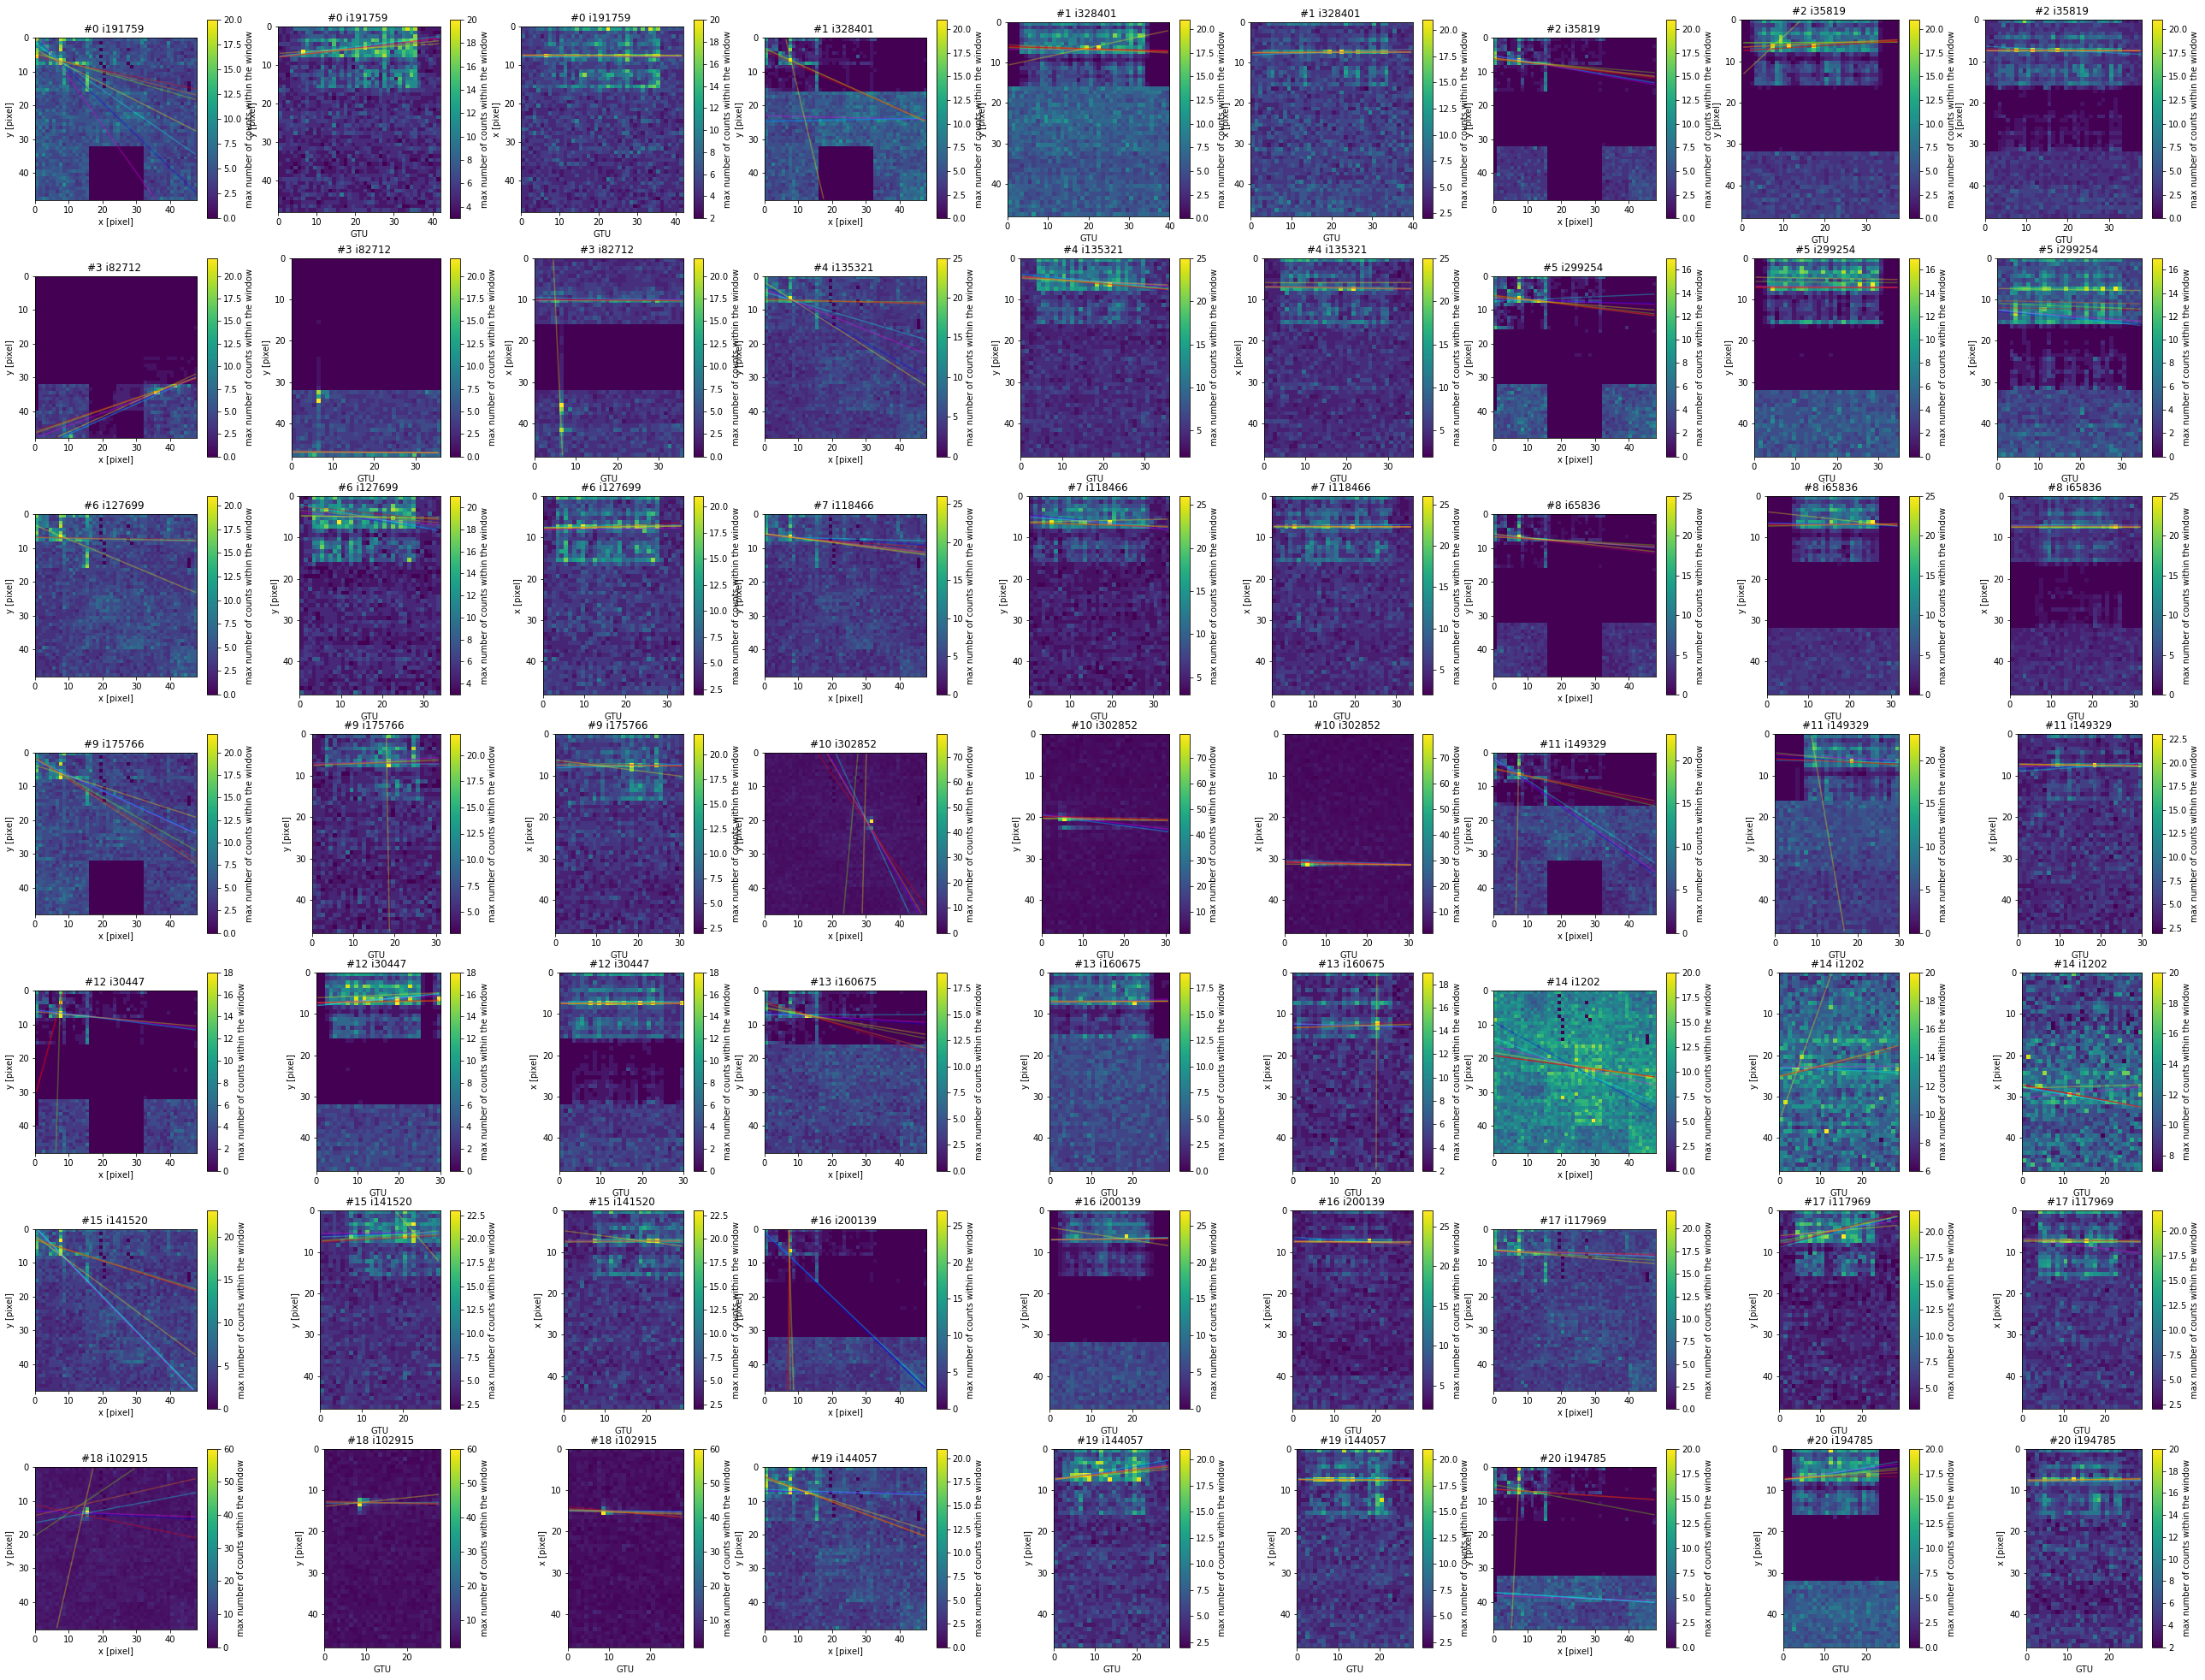

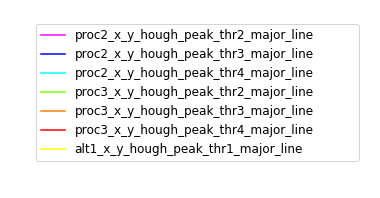

(<matplotlib.axes._subplots.AxesSubplot at 0x7f49e2584908>,
 <matplotlib.figure.Figure at 0x7f49d6c34fd0>)

In [51]:
vis_events_line_colors = ['#FF00FF','#0000FF','#00FFFF','#80FF00','#FF8000','#FF0000','yellow']
vis_events_line_columns_x_y = [('proc2_x_y_hough_peak_thr2_major_line_rho','proc2_x_y_hough_peak_thr2_major_line_phi'),('proc2_x_y_hough_peak_thr3_major_line_rho','proc2_x_y_hough_peak_thr3_major_line_phi'),('proc2_x_y_hough_peak_thr4_major_line_rho','proc2_x_y_hough_peak_thr4_major_line_phi'),('proc3_x_y_hough_peak_thr2_major_line_rho','proc3_x_y_hough_peak_thr2_major_line_phi'),('proc3_x_y_hough_peak_thr3_major_line_rho','proc3_x_y_hough_peak_thr3_major_line_phi'),('proc3_x_y_hough_peak_thr4_major_line_rho','proc3_x_y_hough_peak_thr4_major_line_phi'),('alt1_x_y_hough_peak_thr1_major_line_rho','alt1_x_y_hough_peak_thr1_major_line_phi')] 
vis_events_line_columns_gtu_x = [('proc2_gtu_x_hough_peak_thr2_major_line_rho','proc2_gtu_x_hough_peak_thr2_major_line_phi'),('proc2_gtu_x_hough_peak_thr3_major_line_rho','proc2_gtu_x_hough_peak_thr3_major_line_phi'),('proc2_gtu_x_hough_peak_thr4_major_line_rho','proc2_gtu_x_hough_peak_thr4_major_line_phi'),('proc3_gtu_x_hough_peak_thr2_major_line_rho','proc3_gtu_x_hough_peak_thr2_major_line_phi'),('proc3_gtu_x_hough_peak_thr3_major_line_rho','proc3_gtu_x_hough_peak_thr3_major_line_phi'),('proc3_gtu_x_hough_peak_thr4_major_line_rho','proc3_gtu_x_hough_peak_thr4_major_line_phi'),('alt1_gtu_x_hough_peak_thr1_major_line_rho','alt1_gtu_x_hough_peak_thr1_major_line_phi')] 
vis_events_line_columns_gtu_y = [('proc2_gtu_y_hough_peak_thr2_major_line_rho','proc2_gtu_y_hough_peak_thr2_major_line_phi'),('proc2_gtu_y_hough_peak_thr3_major_line_rho','proc2_gtu_y_hough_peak_thr3_major_line_phi'),('proc2_gtu_y_hough_peak_thr4_major_line_rho','proc2_gtu_y_hough_peak_thr4_major_line_phi'),('proc3_gtu_y_hough_peak_thr2_major_line_rho','proc3_gtu_y_hough_peak_thr2_major_line_phi'),('proc3_gtu_y_hough_peak_thr3_major_line_rho','proc3_gtu_y_hough_peak_thr3_major_line_phi'),('proc3_gtu_y_hough_peak_thr4_major_line_rho','proc3_gtu_y_hough_peak_thr4_major_line_phi'),('alt1_gtu_y_hough_peak_thr1_major_line_rho','alt1_gtu_y_hough_peak_thr1_major_line_phi')] 
vis_events_line_names = [os.path.commonprefix([col_rho,col_phi])[:-1] for col_rho, col_phi in vis_events_line_columns_x_y]


plt.close('all')
vis_events_df(events_to_vis_df, 
              events_per_figure=20, max_figures=1, vis_gtux=True, vis_gtuy=True, 
              close_after_vis=False, show=True, 
#               additional_printed_columns=[
#                   'proc2_gtu_y_gtu_x_hough_peak_thr3_major_line_phi_diff',
#                   'proc2_gtu_y_hough_peak_thr3_major_line_phi_diff_0'],
              line_columns_x_y=vis_events_line_columns_x_y, 
              line_columns_gtu_x=vis_events_line_columns_gtu_x, 
              line_columns_gtu_y=vis_events_line_columns_gtu_y,
             line_colors=vis_events_line_colors, line_alpha=0.3)

draw_lines_legend(vis_events_line_colors, vis_events_line_names)

# #FF00FF  proc2_x_y_hough_peak_thr2_major_line_phi
# #0000FF  proc2_x_y_hough_peak_thr3_major_line_phi
# #00FFFF  proc2_x_y_hough_peak_thr4_major_line_phi
# #80FF00  proc3_x_y_hough_peak_thr2_major_line_phi
# #FF8000  proc3_x_y_hough_peak_thr3_major_line_phi
# #FF0000  proc3_x_y_hough_peak_thr4_major_line_phi
# yellow   alt1_x_y_hough_peak_thr1_major_line_phi

# Distributions

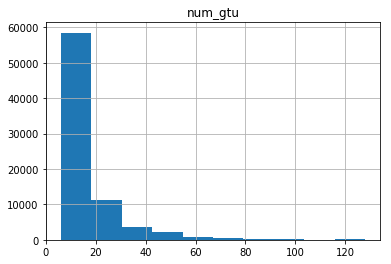

In [20]:
events_df.hist('num_gtu')
plt.show()

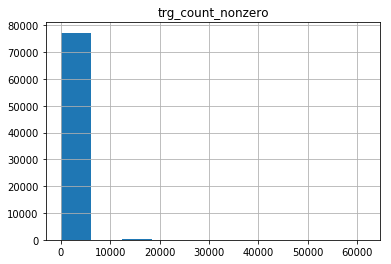

In [21]:
events_df.hist('trg_count_nonzero')
plt.show()

['proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc2_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc3_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width']


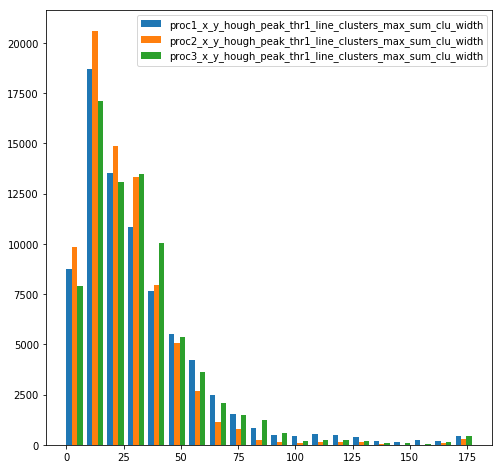

['proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc2_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc3_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width']


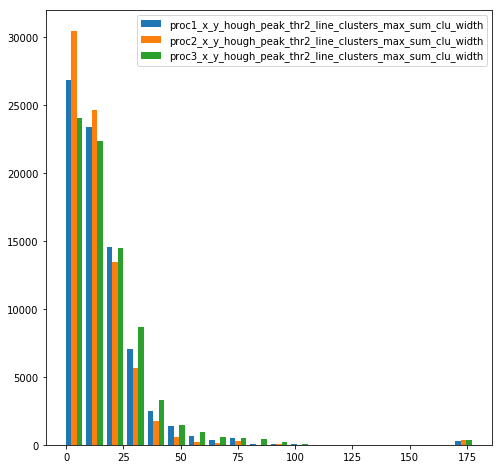

['proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc2_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc3_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width']


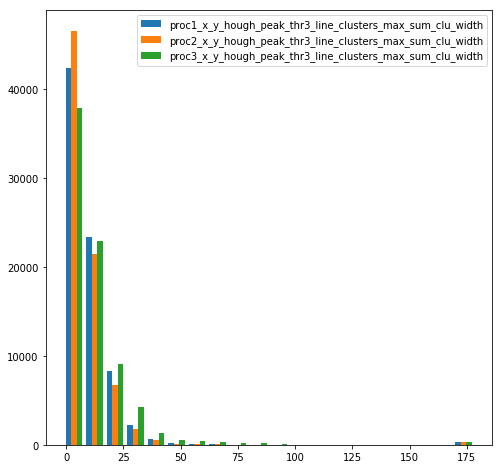

['proc1_x_y_hough_peak_thr4_line_clusters_max_sum_clu_width', 'proc2_x_y_hough_peak_thr4_line_clusters_max_sum_clu_width', 'proc3_x_y_hough_peak_thr4_line_clusters_max_sum_clu_width']


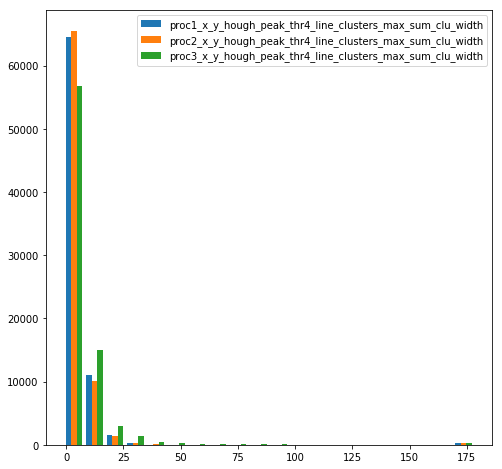

['proc1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width', 'proc2_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width', 'proc3_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width']


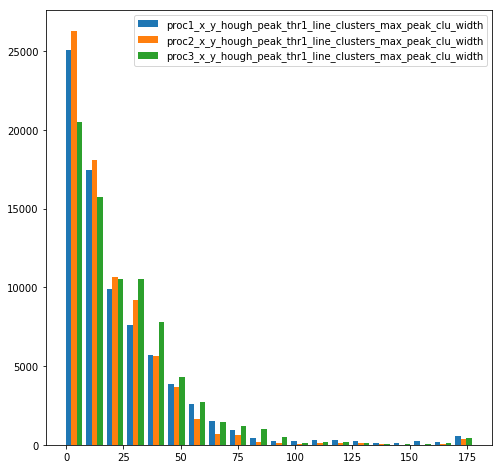

['proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc2_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width']


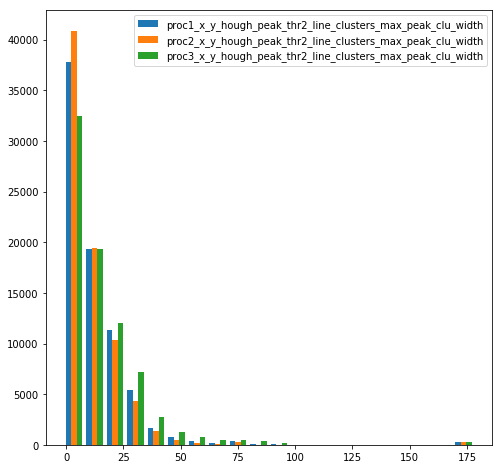

['proc1_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width', 'proc2_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width', 'proc3_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width']


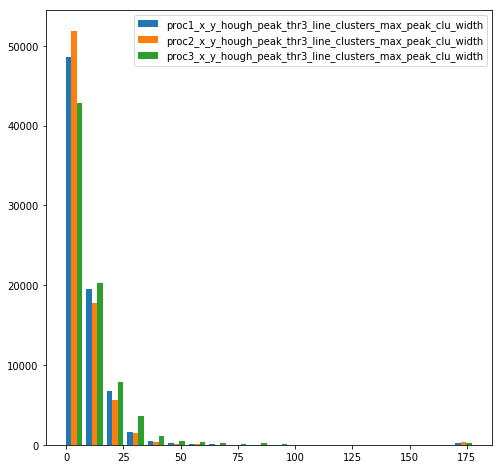

['proc1_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width', 'proc2_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width', 'proc3_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width']


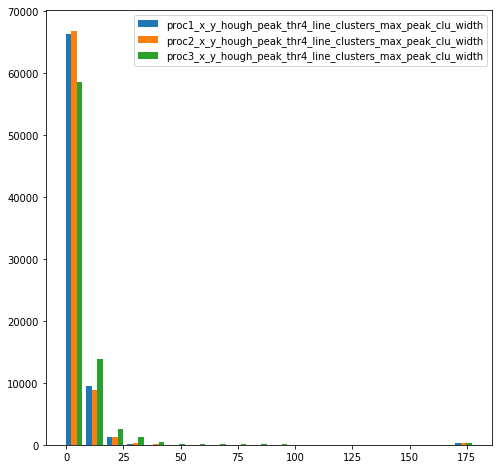

['proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc1_x_y_hough_peak_thr4_line_clusters_max_sum_clu_width']


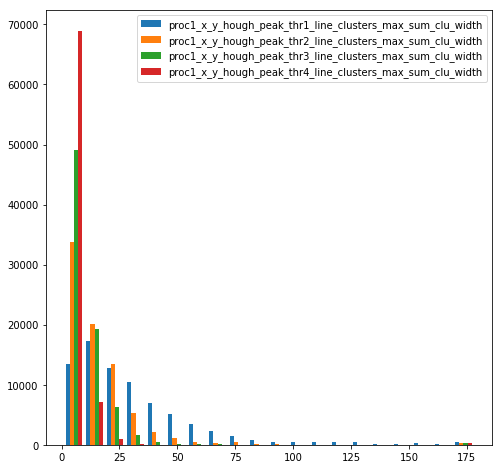

['proc2_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc2_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc2_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc2_x_y_hough_peak_thr4_line_clusters_max_sum_clu_width']


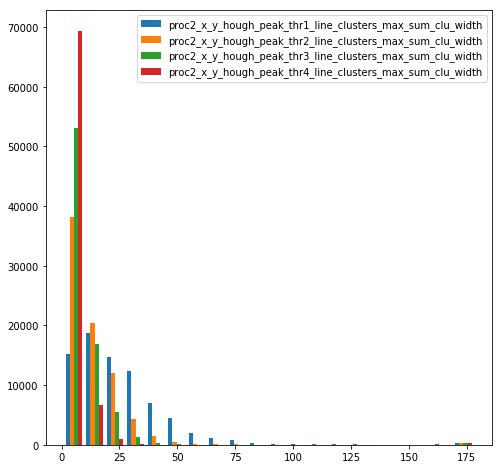

['proc3_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc3_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc3_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc3_x_y_hough_peak_thr4_line_clusters_max_sum_clu_width']


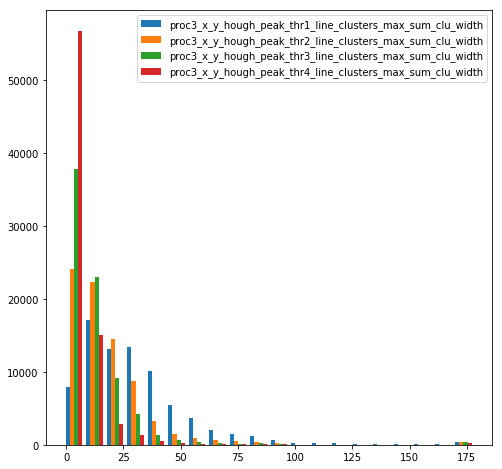

['proc1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width', 'proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc1_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width', 'proc1_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width']


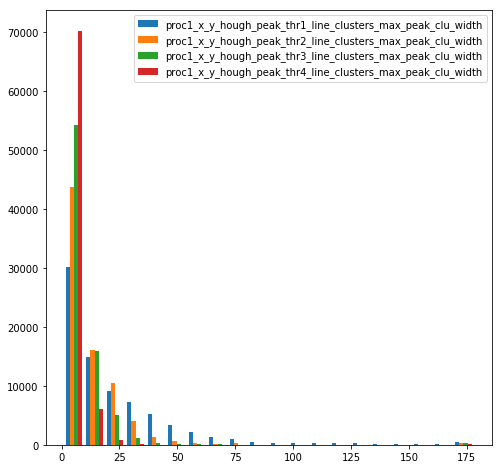

['proc2_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width', 'proc2_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc2_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width', 'proc2_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width']


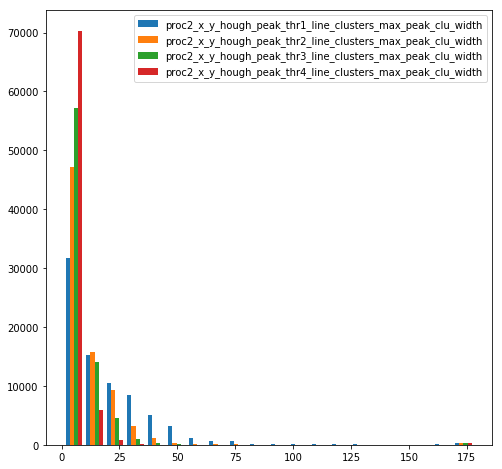

['proc3_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width', 'proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc3_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width', 'proc3_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width']


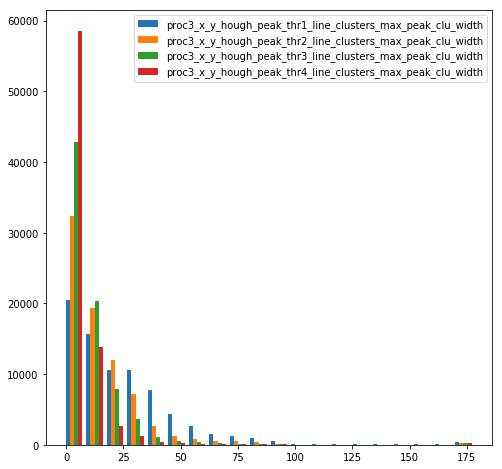

['proc1_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc1_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width']


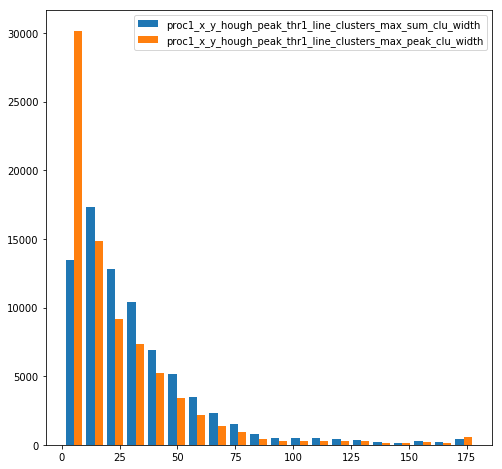

['proc1_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc1_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width']


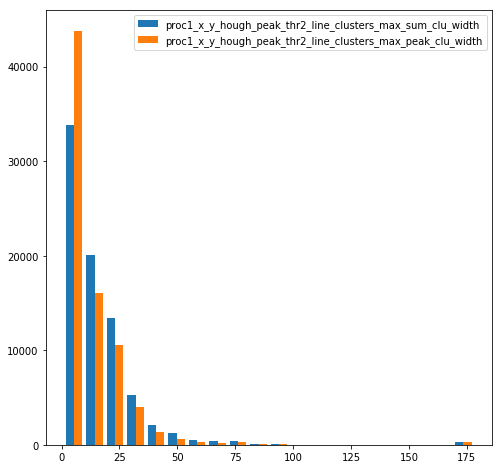

['proc1_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc1_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width']


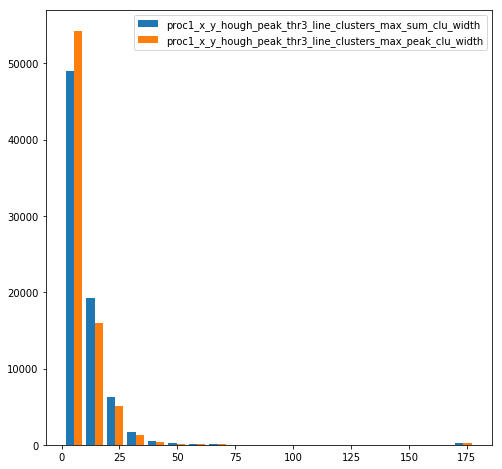

['proc1_x_y_hough_peak_thr4_line_clusters_max_sum_clu_width', 'proc1_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width']


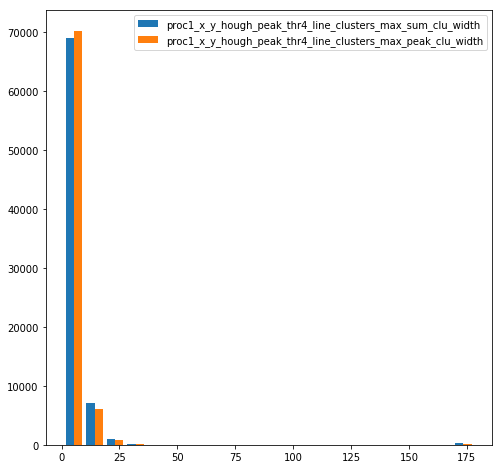

['proc2_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc2_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width']


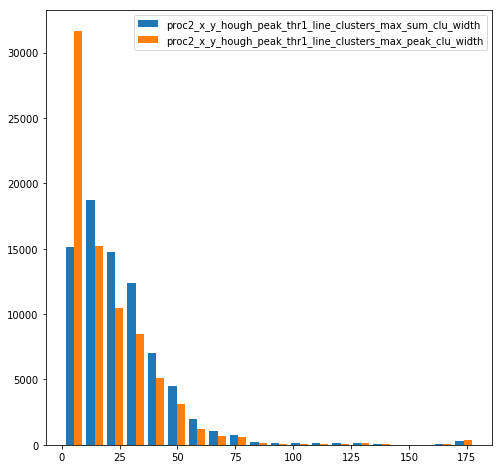

['proc2_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc2_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width']


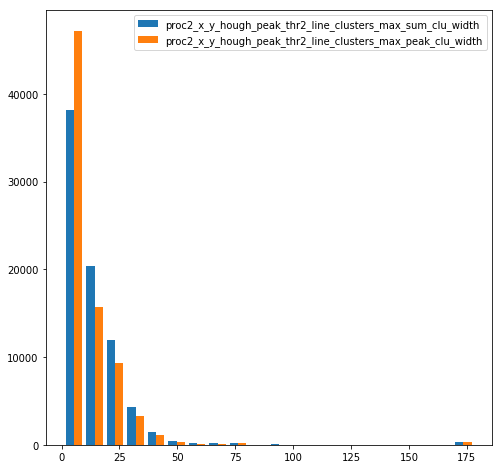

['proc2_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc2_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width']


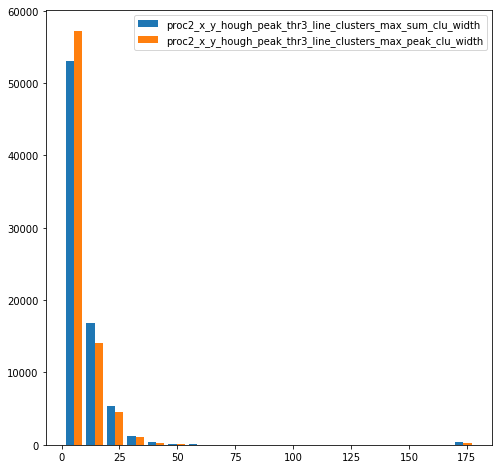

['proc2_x_y_hough_peak_thr4_line_clusters_max_sum_clu_width', 'proc2_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width']


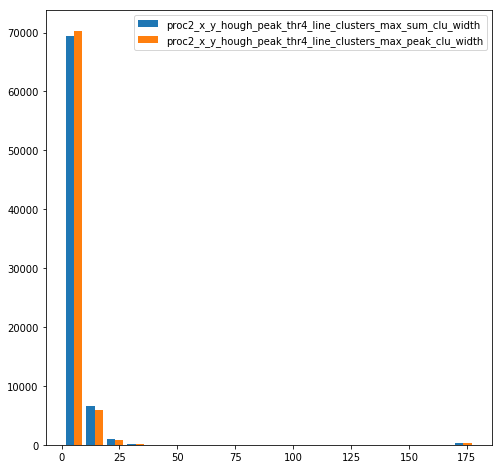

['proc3_x_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc3_x_y_hough_peak_thr1_line_clusters_max_peak_clu_width']


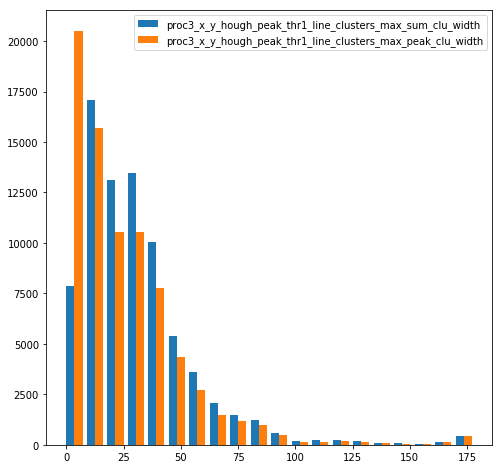

['proc3_x_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc3_x_y_hough_peak_thr2_line_clusters_max_peak_clu_width']


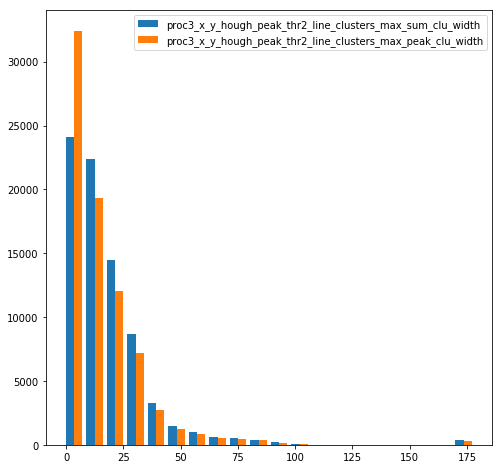

['proc3_x_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc3_x_y_hough_peak_thr3_line_clusters_max_peak_clu_width']


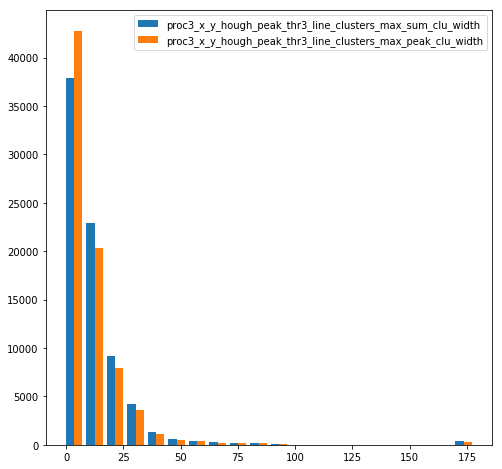

['proc3_x_y_hough_peak_thr4_line_clusters_max_sum_clu_width', 'proc3_x_y_hough_peak_thr4_line_clusters_max_peak_clu_width']


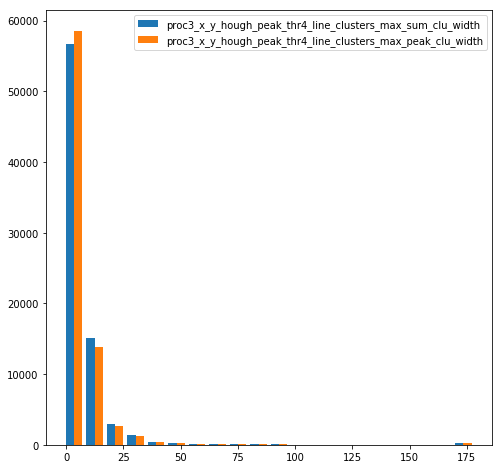

['proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc2_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc3_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width']


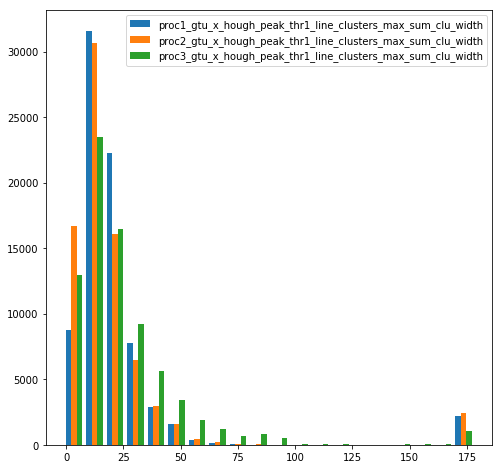

['proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc2_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc3_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width']


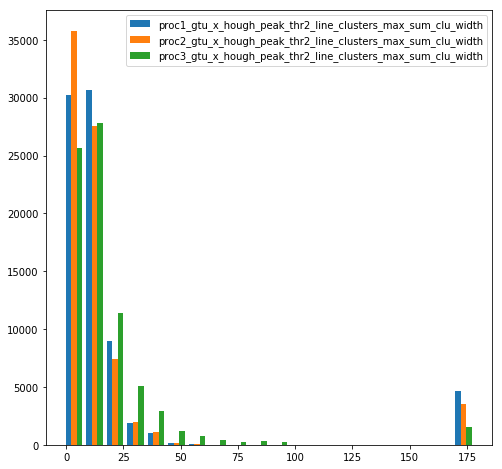

['proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc2_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc3_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width']


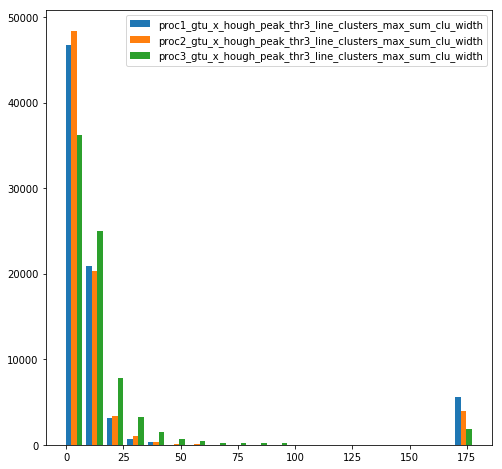

['proc1_gtu_x_hough_peak_thr4_line_clusters_max_sum_clu_width', 'proc2_gtu_x_hough_peak_thr4_line_clusters_max_sum_clu_width', 'proc3_gtu_x_hough_peak_thr4_line_clusters_max_sum_clu_width']


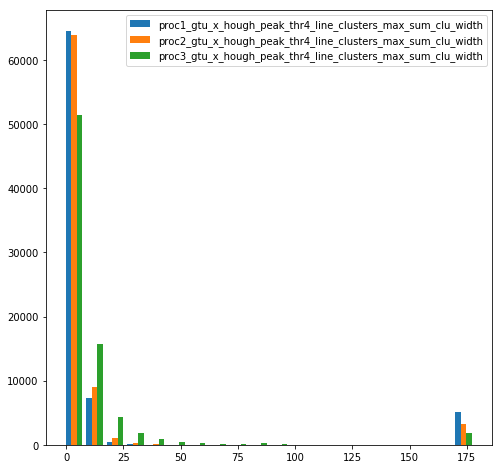

['proc1_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width', 'proc2_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width', 'proc3_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width']


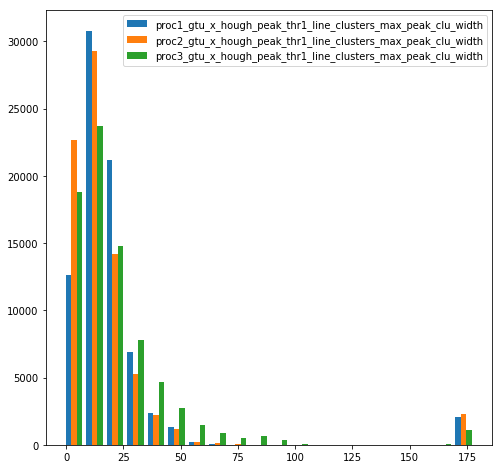

['proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc2_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc3_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width']


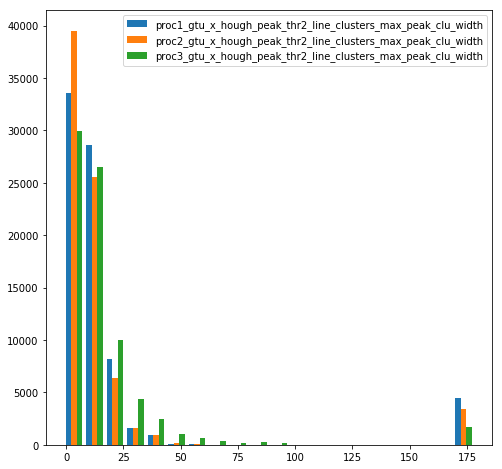

['proc1_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width', 'proc2_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width', 'proc3_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width']


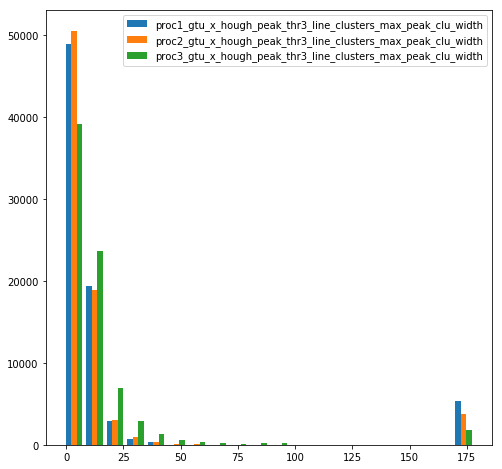

['proc1_gtu_x_hough_peak_thr4_line_clusters_max_peak_clu_width', 'proc2_gtu_x_hough_peak_thr4_line_clusters_max_peak_clu_width', 'proc3_gtu_x_hough_peak_thr4_line_clusters_max_peak_clu_width']


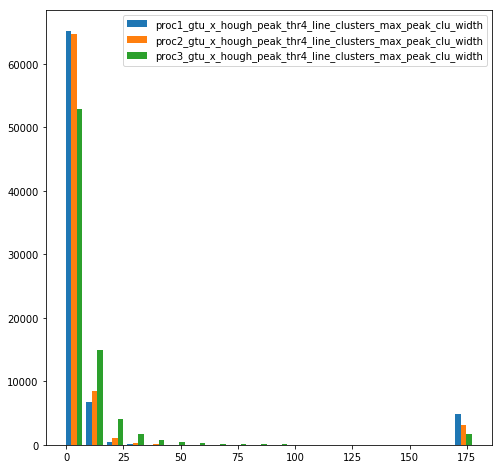

['proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc1_gtu_x_hough_peak_thr4_line_clusters_max_sum_clu_width']


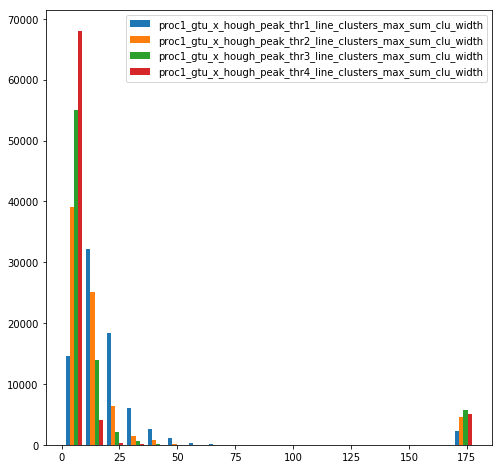

['proc2_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc2_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc2_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc2_gtu_x_hough_peak_thr4_line_clusters_max_sum_clu_width']


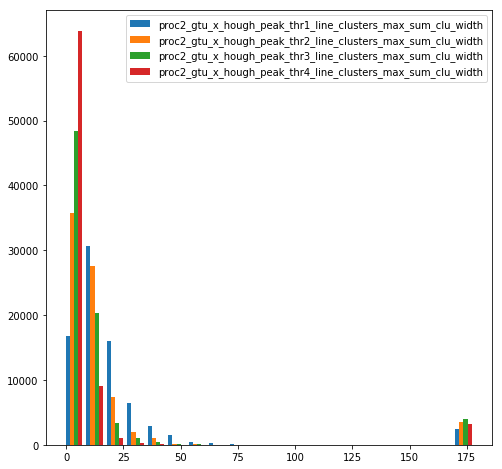

['proc3_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc3_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc3_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc3_gtu_x_hough_peak_thr4_line_clusters_max_sum_clu_width']


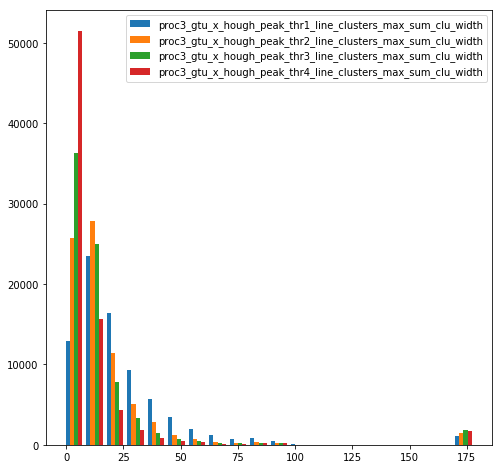

['proc1_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width', 'proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc1_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width', 'proc1_gtu_x_hough_peak_thr4_line_clusters_max_peak_clu_width']


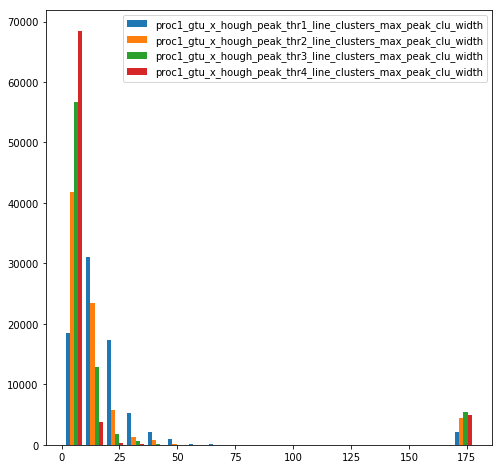

['proc2_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width', 'proc2_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc2_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width', 'proc2_gtu_x_hough_peak_thr4_line_clusters_max_peak_clu_width']


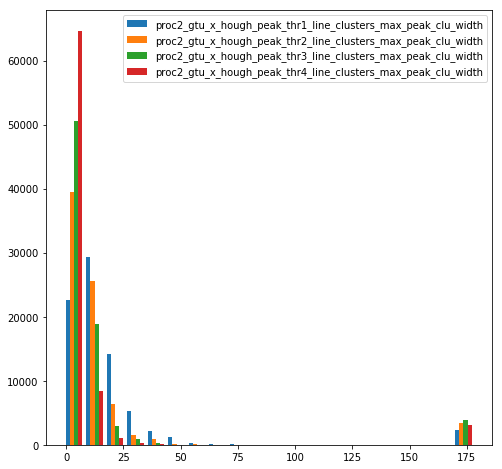

['proc3_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width', 'proc3_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc3_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width', 'proc3_gtu_x_hough_peak_thr4_line_clusters_max_peak_clu_width']


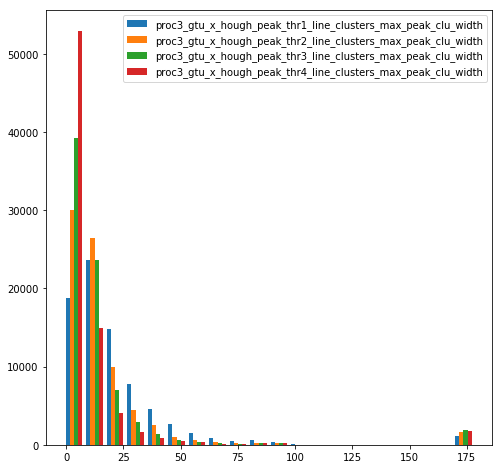

['proc1_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc1_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width']


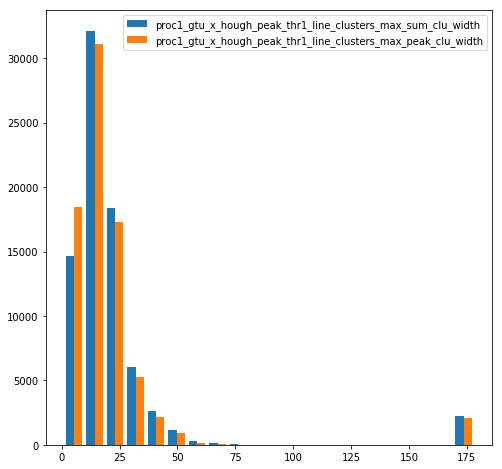

['proc1_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc1_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width']


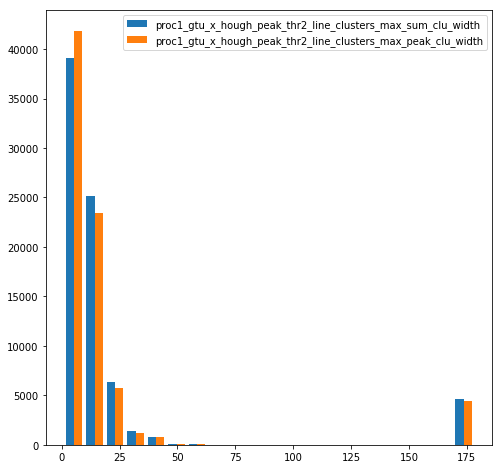

['proc1_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc1_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width']


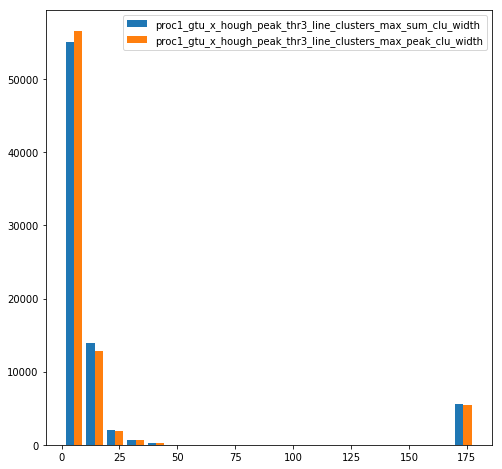

['proc1_gtu_x_hough_peak_thr4_line_clusters_max_sum_clu_width', 'proc1_gtu_x_hough_peak_thr4_line_clusters_max_peak_clu_width']


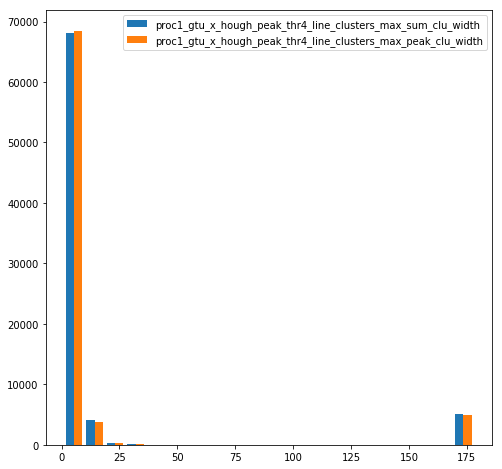

['proc2_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc2_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width']


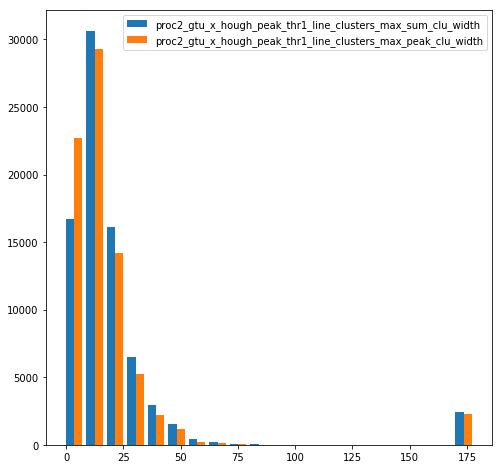

['proc2_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc2_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width']


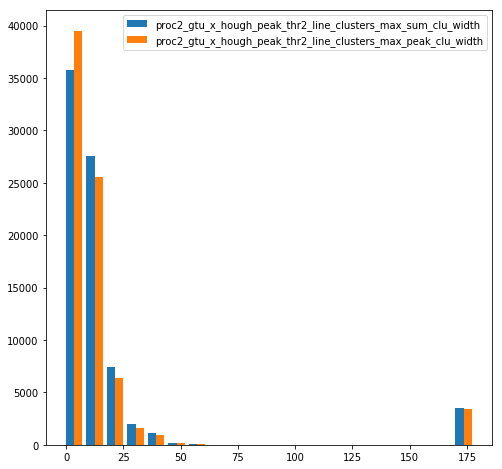

['proc2_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc2_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width']


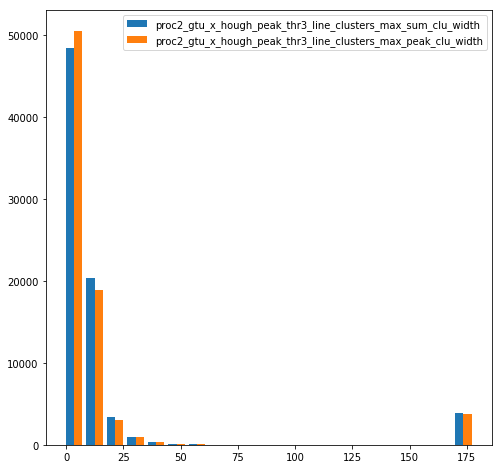

['proc2_gtu_x_hough_peak_thr4_line_clusters_max_sum_clu_width', 'proc2_gtu_x_hough_peak_thr4_line_clusters_max_peak_clu_width']


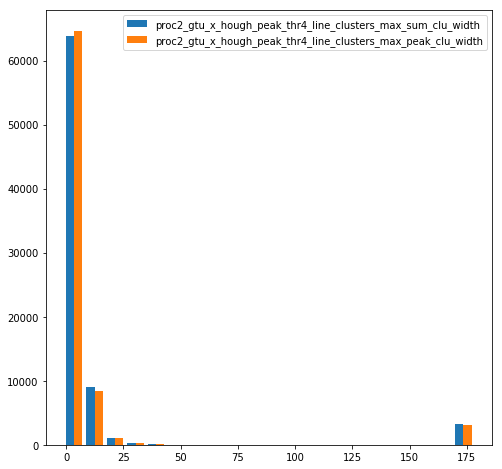

['proc3_gtu_x_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc3_gtu_x_hough_peak_thr1_line_clusters_max_peak_clu_width']


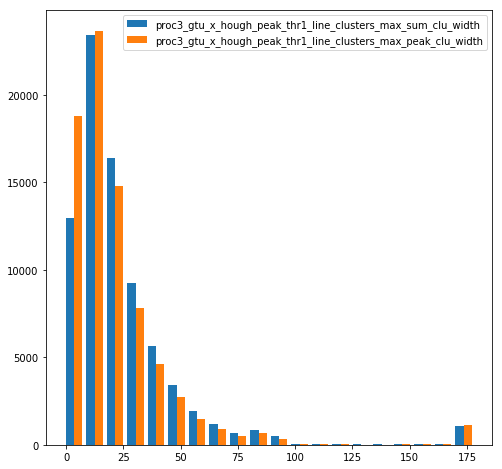

['proc3_gtu_x_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc3_gtu_x_hough_peak_thr2_line_clusters_max_peak_clu_width']


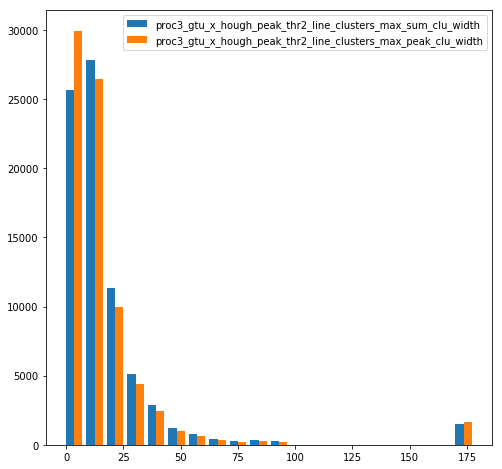

['proc3_gtu_x_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc3_gtu_x_hough_peak_thr3_line_clusters_max_peak_clu_width']


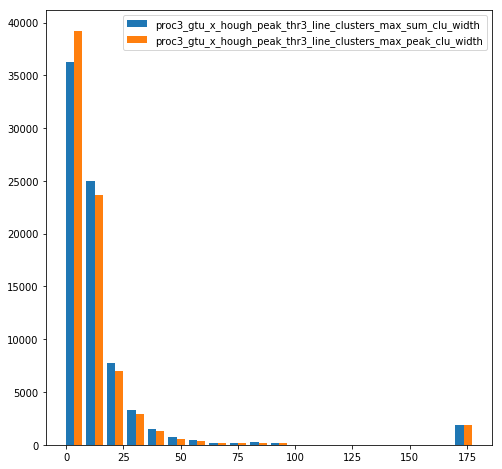

['proc3_gtu_x_hough_peak_thr4_line_clusters_max_sum_clu_width', 'proc3_gtu_x_hough_peak_thr4_line_clusters_max_peak_clu_width']


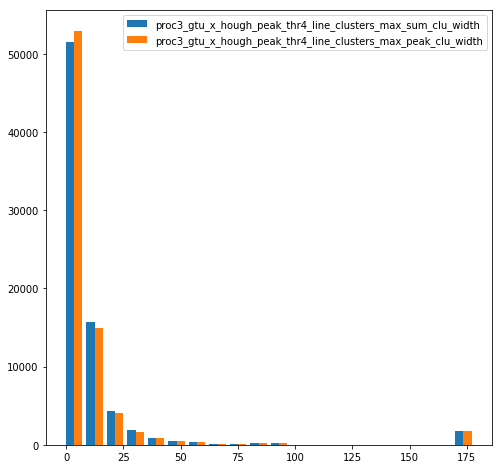

['proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc2_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc3_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width']


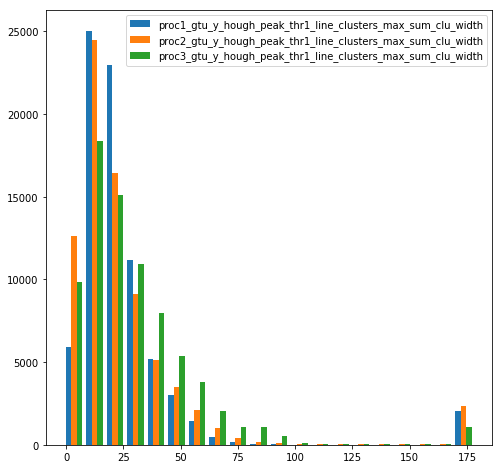

['proc1_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc2_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc3_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width']


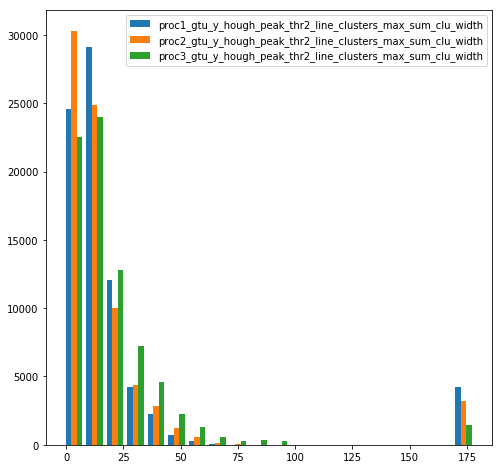

['proc1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc2_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc3_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width']


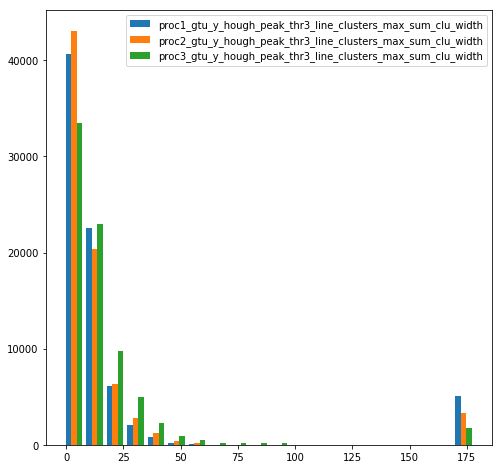

['proc1_gtu_y_hough_peak_thr4_line_clusters_max_sum_clu_width', 'proc2_gtu_y_hough_peak_thr4_line_clusters_max_sum_clu_width', 'proc3_gtu_y_hough_peak_thr4_line_clusters_max_sum_clu_width']


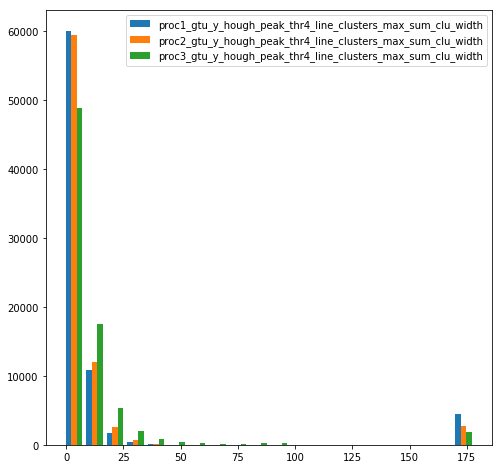

['proc1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width', 'proc2_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width', 'proc3_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width']


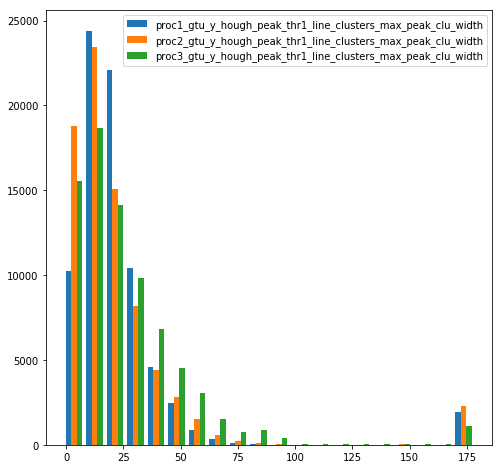

['proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc2_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc3_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width']


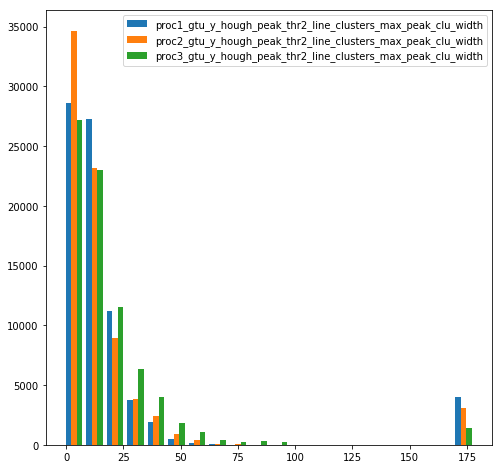

['proc1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width', 'proc2_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width', 'proc3_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width']


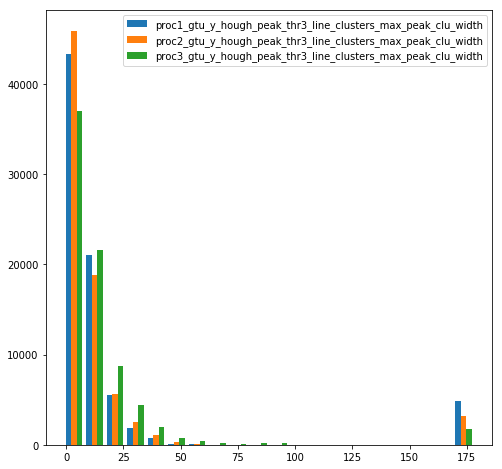

['proc1_gtu_y_hough_peak_thr4_line_clusters_max_peak_clu_width', 'proc2_gtu_y_hough_peak_thr4_line_clusters_max_peak_clu_width', 'proc3_gtu_y_hough_peak_thr4_line_clusters_max_peak_clu_width']


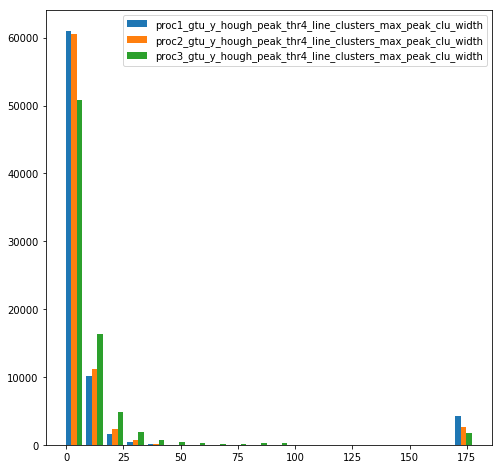

['proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc1_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc1_gtu_y_hough_peak_thr4_line_clusters_max_sum_clu_width']


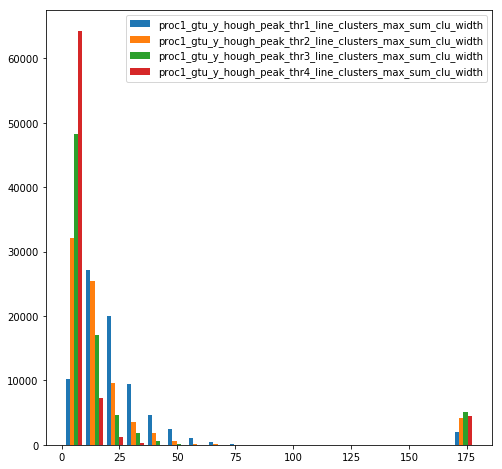

['proc2_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc2_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc2_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc2_gtu_y_hough_peak_thr4_line_clusters_max_sum_clu_width']


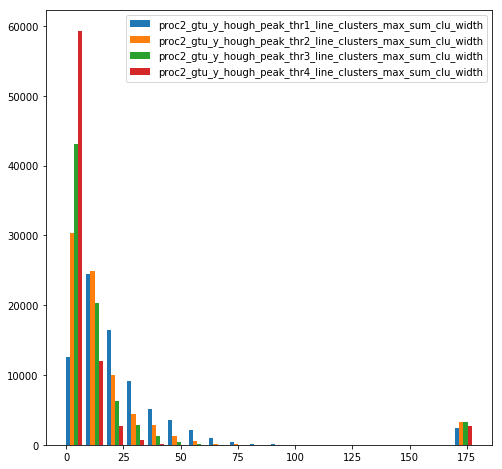

['proc3_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc3_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc3_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc3_gtu_y_hough_peak_thr4_line_clusters_max_sum_clu_width']


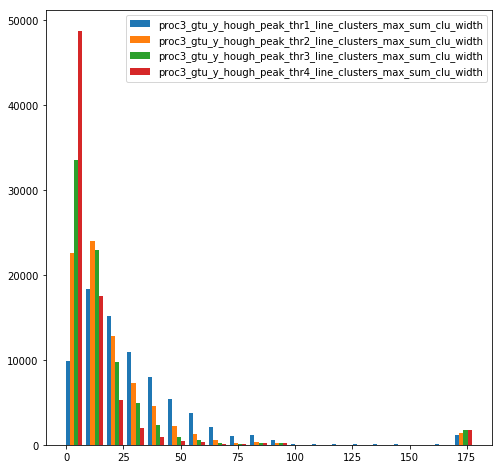

['proc1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width', 'proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width', 'proc1_gtu_y_hough_peak_thr4_line_clusters_max_peak_clu_width']


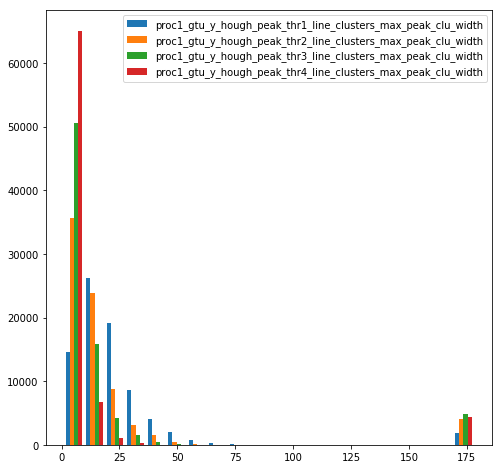

['proc2_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width', 'proc2_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc2_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width', 'proc2_gtu_y_hough_peak_thr4_line_clusters_max_peak_clu_width']


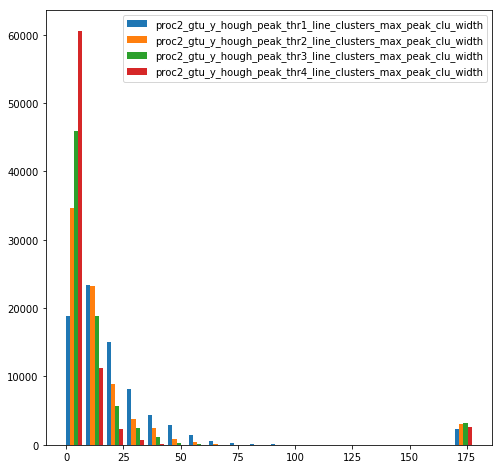

['proc3_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width', 'proc3_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width', 'proc3_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width', 'proc3_gtu_y_hough_peak_thr4_line_clusters_max_peak_clu_width']


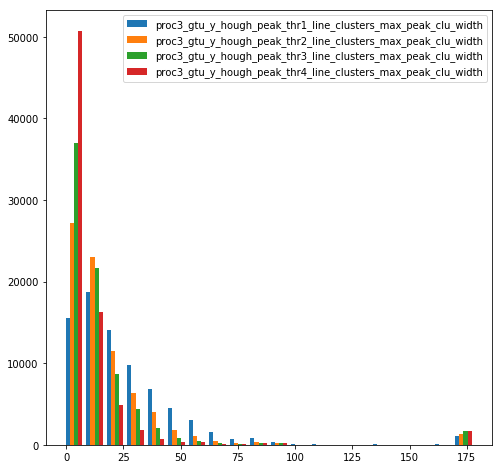

['proc1_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc1_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width']


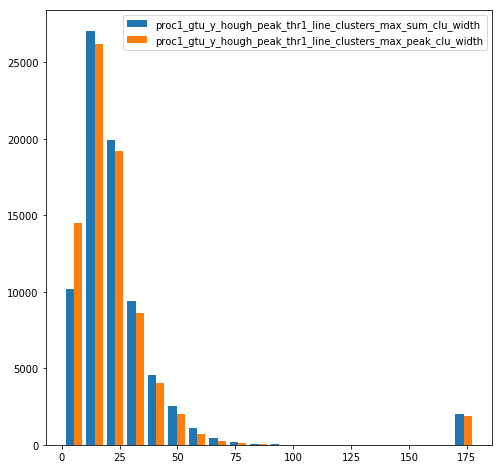

['proc1_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc1_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width']


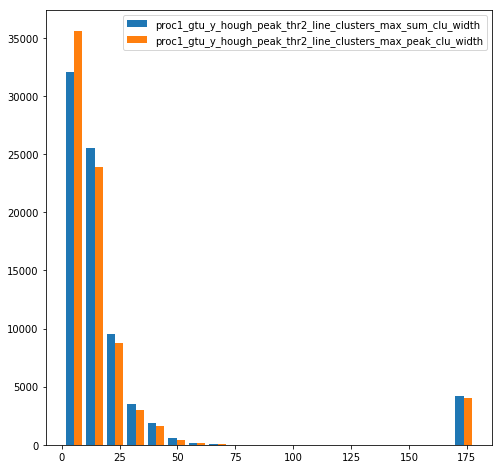

['proc1_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc1_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width']


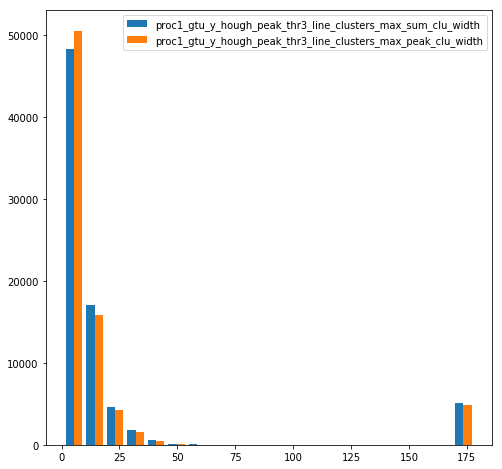

['proc1_gtu_y_hough_peak_thr4_line_clusters_max_sum_clu_width', 'proc1_gtu_y_hough_peak_thr4_line_clusters_max_peak_clu_width']


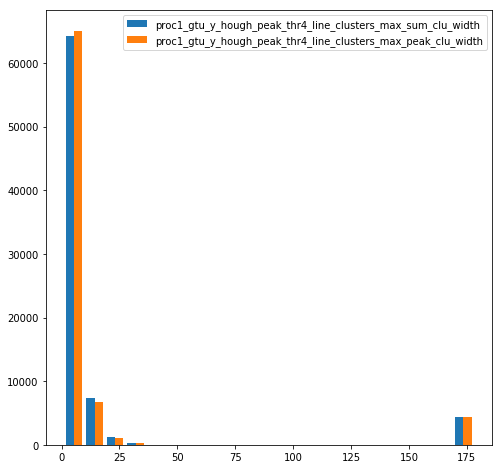

['proc2_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc2_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width']


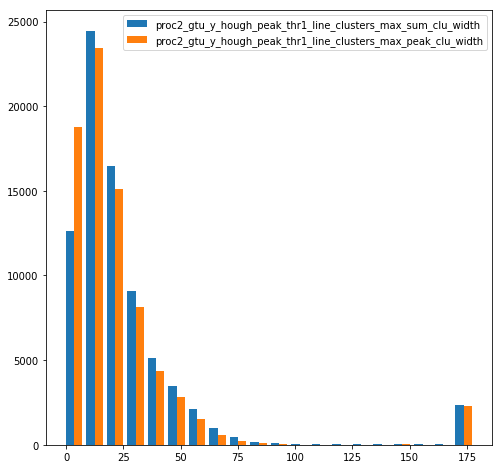

['proc2_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc2_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width']


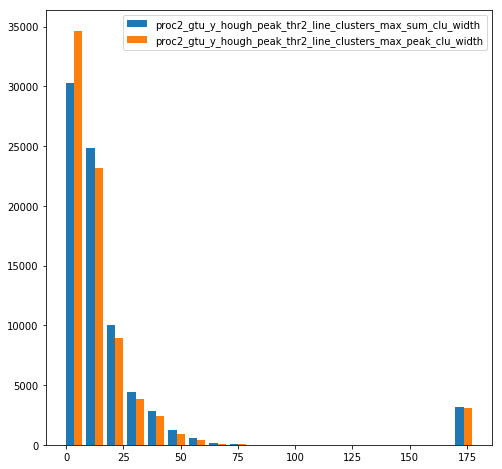

['proc2_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc2_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width']


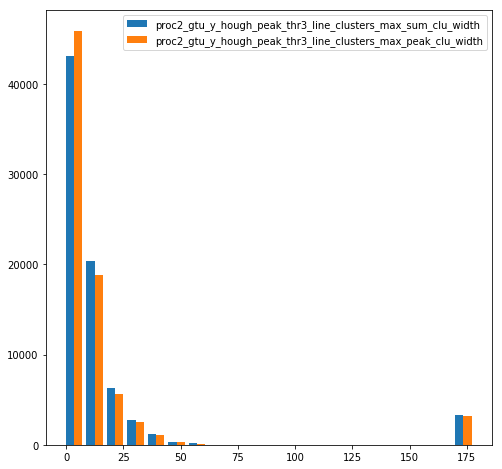

['proc2_gtu_y_hough_peak_thr4_line_clusters_max_sum_clu_width', 'proc2_gtu_y_hough_peak_thr4_line_clusters_max_peak_clu_width']


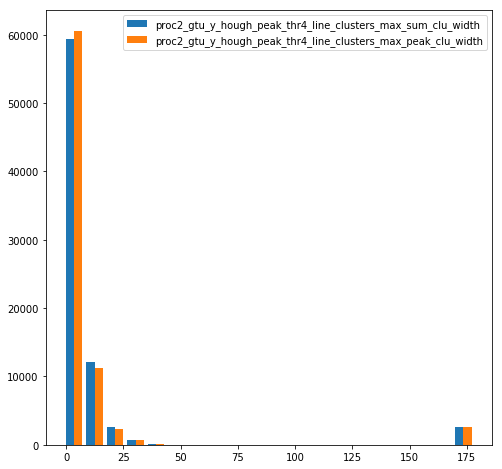

['proc3_gtu_y_hough_peak_thr1_line_clusters_max_sum_clu_width', 'proc3_gtu_y_hough_peak_thr1_line_clusters_max_peak_clu_width']


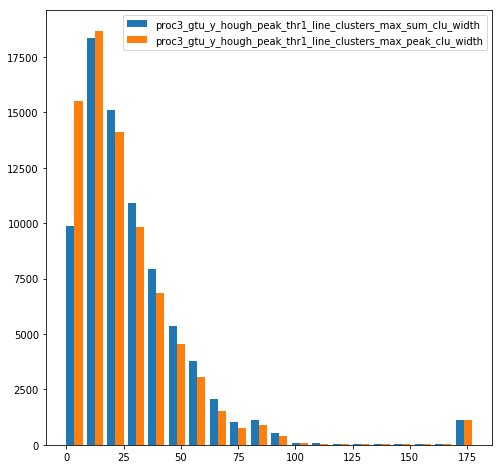

['proc3_gtu_y_hough_peak_thr2_line_clusters_max_sum_clu_width', 'proc3_gtu_y_hough_peak_thr2_line_clusters_max_peak_clu_width']


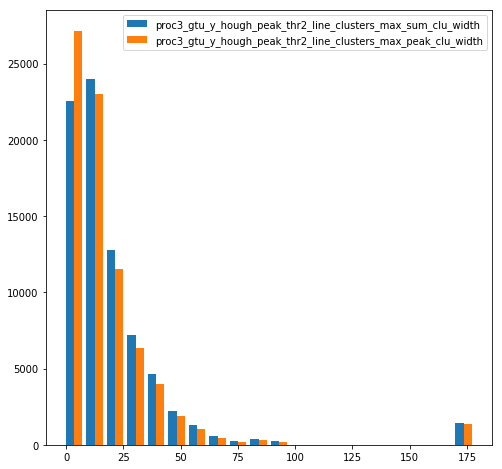

['proc3_gtu_y_hough_peak_thr3_line_clusters_max_sum_clu_width', 'proc3_gtu_y_hough_peak_thr3_line_clusters_max_peak_clu_width']


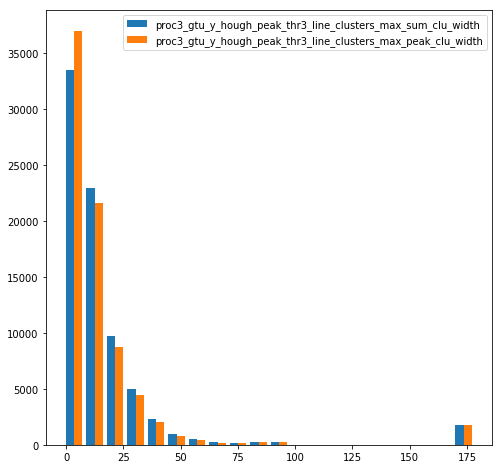

['proc3_gtu_y_hough_peak_thr4_line_clusters_max_sum_clu_width', 'proc3_gtu_y_hough_peak_thr4_line_clusters_max_peak_clu_width']


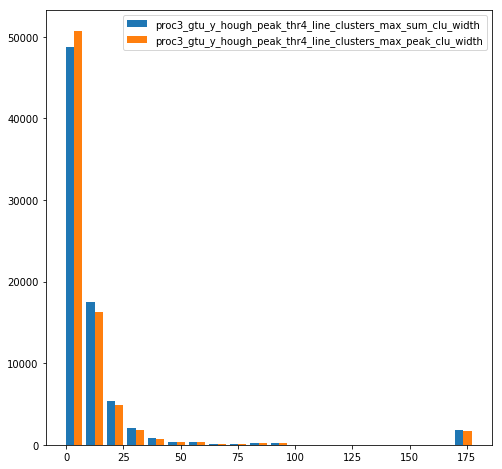

In [22]:
col_format = 'proc{proci}_{proj_type}_hough_peak_thr{thri}_line_clusters_max_{clu_type}_clu_width'

for proj_type in ['x_y','gtu_x', 'gtu_y']:
    for clu_type in ['sum','peak']:
        for thri in [1,2,3,4]:
            cmp_l = []
            for proci in [1,2,3]:
                cmp_l.append(col_format.format(proci=proci, proj_type=proj_type, thri=thri, clu_type=clu_type))
            
            print(cmp_l)
            fig,ax = plt.subplots(1)
            ax.hist(events_df[cmp_l].values, 20, histtype='bar', label=cmp_l) 
            ax.legend(prop={'size': 10})
            fig.set_size_inches(8,8)
            plt.show()
            
    for clu_type in ['sum','peak']:
        for proci in [1,2,3]:
            cmp_l = []
            for thri in [1,2,3,4]:
                cmp_l.append(col_format.format(proci=proci, proj_type=proj_type, thri=thri, clu_type=clu_type))
            
            print(cmp_l)
            fig,ax = plt.subplots(1)
            ax.hist(events_df[cmp_l].values, 20, histtype='bar', label=cmp_l) 
            ax.legend(prop={'size': 10})
            fig.set_size_inches(8,8)
            plt.show()

    for proci in [1,2,3]:
        for thri in [1,2,3,4]:
            cmp_l = []
            for clu_type in ['sum','peak']:
                cmp_l.append(col_format.format(proci=proci, proj_type=proj_type, thri=thri, clu_type=clu_type))
            
            print(cmp_l)
            fig,ax = plt.subplots(1)
            ax.hist(events_df[cmp_l].values, 20, histtype='bar', label=cmp_l) 
            ax.legend(prop={'size': 10})
            fig.set_size_inches(8,8)
            plt.show()
            